In [1]:
import os, mediacloud.api
from importlib.metadata import version
from dotenv import load_dotenv
import datetime as dt
from IPython.display import JSON
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
MC_API_KEY = '8cd5d1c09a6cd8a96104697b686cb665f57715f3'
search_api = mediacloud.api.SearchApi(MC_API_KEY)
f'Using Media Cloud python client v{version("mediacloud")}'
import pandas as pd
import lda

Loading BokehJS ...

## Scrape data

In [ ]:
# import requests
# import time
# my_query = "US election" # note the double quotes used to indicate use of the whole phrase
# start_date = dt.date(2024, 1, 15)
# end_date = dt.date(2024, 11, 5)

# # source_ids = [1, 2, 4, 6, 1089, 18482, 1096, 18342, 1092, 1095, 1110, 1101, 1752]
# source_ids = [1093] 
# #1089, 18482, 1096, 18342, 1092, 18775, 19334, 7

# # Fetch stories from Media Cloud API for the interested presses
# all_stories_test_14  = []
# for source_id in source_ids:
#     print(f'Fetching stories from source {source_id}')
#     stories, _ = search_api.story_list(my_query, start_date, end_date, source_ids=[source_id])
#     all_stories_test_14.extend(stories)

# # Create a DataFrame with columns headlines, source name, and datetime
# # story = search_api.story_list(my_query, start_date, end_date, source_ids=[4])
# # print(story)


Fetching stories from source 1093


In [ ]:
# all_stories_left =  all_stories_test_1 + all_stories_test_2 + all_stories_test_3 + all_stories_test_4 + all_stories_test_5
# all_stories_right = all_stories_test_6 + all_stories_test_7 + all_stories_test_8 + all_stories_test_9
# all_stories_center = all_stories_test_10 + all_stories_test_11 + all_stories_test_12 + all_stories_test_13 + all_stories_test_14

In [ ]:
# all_stories = all_stories_left + all_stories_right + all_stories_center

In [195]:
df = pd.DataFrame([{'headline': story['title'], 'source_name': story['media_name'], 'datetime': story['publish_date']} for story in all_stories])

# Save the DataFrame to a CSV file
leaning_map = {
    'Left': ['nytimes.com', 'thenation.com', 'latimes.com','cnn.com', 'motherjones.com'],
    'Center': ['reuters.com', 'usatoday.com', 'bloomberg.com', 'npr.org','pbs.org'],
    'Right': ['foxnews.com', 'nypost.com', 'breitbart.com','hotair.com']
}
# Assign leaning based on the source_name column
def get_leaning(source_name):
    for leaning, sources in leaning_map.items():
        if source_name in sources:
            return leaning
    return 'Unknown'

df['leaning'] = df['source_name'].apply(get_leaning)

print(df.head())
print(df.shape)

                                            headline  source_name    datetime  \
0                 The Election Is Happening Too Soon  nytimes.com  2024-10-24   
1                                            Opinion  nytimes.com  2024-10-13   
2  ‘Joy’ Is Working for Harris, but Can It Close ...  nytimes.com  2024-10-09   
3  What the initial CFP rankings mean, plus a his...  nytimes.com  2024-11-05   
4  Election Day Is Long. Give Us Five Minutes to ...  nytimes.com  2024-11-05   

  leaning  
0    Left  
1    Left  
2    Left  
3    Left  
4    Left  
(10693, 4)


In [ ]:
# df.to_csv('stories.csv', index=False)

df = pd.read_csv('stories.csv')


In [222]:
df = df[~df['headline'].str.contains('hurricane|milton|weather', case=False, na=False)]
df = df[~df['headline'].str.startswith("The week’s bestselling books", na=False)]

In [223]:
df_left = df[df['leaning'] == 'Left']
df_right = df[df['leaning'] == 'Right']
df_center = df[df['leaning'] == 'Center']

In [224]:
df_left = df_left.assign(datetime=pd.to_datetime(df_left['datetime'])).set_index('datetime').sort_index()
df_right = df_right.assign(datetime=pd.to_datetime(df_right['datetime'])).set_index('datetime').sort_index()
df_center = df_center.assign(datetime=pd.to_datetime(df_center['datetime'])).set_index('datetime').sort_index()

In [225]:

df_left = df_left[df_left['source_name'] != 'motherjones.com']

print(df_left.shape)
print(df_right.shape)
print(df_center.shape)

(3940, 3)
(3686, 3)
(2574, 3)


## Preprocessing

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nrclex import NRCLex
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# custom_stopwords = set(stopwords.words("english")).union({
#     "slot", "form", "store", "basis", "digest", "projected", "say", 
# })

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Combine all headlines into a single text
headlines = df['headline'].str.cat(sep=' ')

# Tokenize the text
tokens = word_tokenize(headlines)

# Filter and lemmatize tokens using spaCy
filtered_tokens = [
    token.lemma_.lower()  # Lemmatize the word
    for token in nlp(' '.join(tokens))
    if token.is_alpha and token.text.lower() not in stop_words  # Exclude stopwords and non-alphabetic tokens
]

synonym_map = {
    "politics": "politic",
    "political": "politic",
    "politician": "politic",
    'american' : 'america',
    'voting' : 'vote',
    'voters' : 'vote',
    'voter' : 'vote',
}
# Apply synonym mapping
filtered_tokens = [synonym_map.get(token, token) for token in filtered_tokens]

# Print some lemmatized tokens
print(filtered_tokens[:20])

# def preprocess_text(text):
#     text = re.sub(r'\d+', '', text)  # Remove numbers
#     text = text.lower()  # Convert to lowercase
#     text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
#     doc = nlp(text)  # Process with spaCy
#     tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in custom_stopwords]
#     return tokens

# # Load your dataset (assume 'headline' column contains text)
# df = pd.read_csv("your_dataset.csv")
# df["processed_text"] = df["headline"].apply(preprocess_text)

# # Create dictionary and corpus for LDA
# dictionary = Dictionary(df["processed_text"])
# corpus = [dictionary.doc2bow(text) for text in df["processed_text"]]

# # Save preprocessed data if needed
# df.to_csv("cleaned_headlines.csv", index=False)


In [ ]:
# Define a normalization dictionary for entity names
entity_normalization = {
    'kamala harris': 'kamala harris',
    'kamala': 'kamala harris',
    'harris': 'kamala harris',
    'donald trump': 'donald trump',
    'donald': 'donald trump',
    'trump': 'donald trump',
    'tim walz': 'tim walz',
    'tim': 'tim walz',
    'walz': 'tim walz',
    'joe biden': 'joe biden',
    'biden': 'joe biden',
    'joe': 'joe biden',
    'vance': 'jd vance',
    # Add more mappings as needed
}

# Normalize the filtered tokens
normalized_tokens = []
for token in filtered_tokens:
    token_text = token.lower()
    if token_text in entity_normalization:
        normalized_tokens.append(entity_normalization[token_text])
    else:
        # Split combined names
        split_names = token_text.split()
        for name in split_names:
            if name in entity_normalization:
                normalized_tokens.append(entity_normalization[name])
            else:
                normalized_tokens.append(name)

# Further normalize any remaining single names
final_normalized_tokens = []
for token in normalized_tokens:
    if token in entity_normalization:
        final_normalized_tokens.append(entity_normalization[token])
    else:
        final_normalized_tokens.append(token)

# Display the normalized tokens
print(final_normalized_tokens[:20])

## EDA

### WordCloud

In [401]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Define trivial words and synonym map
trivial_words = {
    'donald', 'trump', 'harris', 'kamala', 'jd', 'vance', 'obama', 'biden', 'joe', 'walz', 'tim', 'day', 'week', 'month', 'year', 'time', 'nightly', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'election', 'u', 'one', 'would', 'like','president', 'state', 'presidential', 'national', 'brief','even','politic',
    'election', 'u', 'one', 'would', 'like','president', 'state', 'presidential', 'national', 'brief','even','politic', 'letter','editor','edition','pm','am', 'convention','ballot','party','supreme','court','column','right','left','toplines','timessiena',
    'campaign', 'nation', 'people', 'america', 'go', 'poll', 'take', 'back', 'debate', 'say', 'see', 'cnn', 'abc','cbs','hotair','watch','register',
    'vote', 'forecast', 'kdka', 'weather', 'politic', 'morning', 'first', 'tv', 'new', 'make', 'call', 'evening', 'talk', 'live', 'get', 'update', 'news', 'candidate', 'fox', 'medium','bloomberg', 'afternoon',
    'exclusive', 'republican', 'democrat', 'could', 'may', 'might', 'would', 'like', 'top', 'report','us','vp','white','house','house','senate','congress','congressman','congresswoman','senator',
    'opinion','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january','february','march','april','may','june','july','august','september','october','november','december'
}

synonym_map = {
    "politics": "politic", "political": "politic", "politician": "politic", 
    "leader":"lead","leaders":"lead","leading":"lead",
    'american': 'america', 'americans': 'america', 'usa': 'america', 'us': 'america',
    'voting': 'vote', 'voters': 'vote', 'voter': 'vote',
    'migrant': 'immigration', 'immigrations': 'immigration', 'migration': 'immigration', 'migrants': 'immigration',
    'economic': 'economy', 'economics': 'economy', 'economical': 'economy','economics': 'economy',
    'taiwan': 'china', 'taiwanese': 'china', 'beijing': 'china', 'chinese': 'china',
    'palestine': 'israel', 'palestinian': 'israel', 'israeli': 'israel','palestines':'israel',
    'gop': 'republican', 'dem': 'democrat', 'dnc': 'democrat', 'rnc': 'republican', 'democrats': 'democrat', 'republicans': 'republican','dems':'democrat','reps':'republican',
    'congressman': 'congress', 'congresswoman': 'congress',
    'gay': 'gender', 'lgbt': 'gender', 'lgbtq': 'gender', 'gender': 'lgbtq', 'gender': 'lgbtq', 'gender': 'gender','transgender' : 'gender','trans':'gender','queer':'gender','pride flag':'gender','samesex':'gender',
}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define custom stopwords
custom_stopwords = set(stopwords.words("english")).union(trivial_words)

# Function to preprocess text: lowercasing, lemmatization, synonym replacement, and stopword removal
def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    
    text = re.sub(r"\’s", "", text)  # Remove possessive 's
    text = re.sub(r"\"", "", text)  # Remove possessive "
    text = re.sub(r"(?<!same)-", " ", text)   # Split hyphenated words except 'same-sex'
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    
    words = text.lower().split()
    processed_words = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        if lemma == word:  # If the word is not changed, it might be a noun
            lemma = lemmatizer.lemmatize(word, pos='n')
        processed_words.append(synonym_map.get(lemma, lemma))
    
    filtered_words = [word for word in processed_words if word not in custom_stopwords]
    
    return ' '.join(filtered_words)

# Apply preprocessing to entire column
left_tokens = df_left.copy()['headline'].apply(preprocess_text)
center_tokens = df_center.copy()['headline'].apply(preprocess_text)
right_tokens = df_right.copy()['headline'].apply(preprocess_text)
df_left['filtered_headline'] = left_tokens
df_center['filtered_headline'] = center_tokens
df_right['filtered_headline'] = right_tokens

# Function to preprocess text: lowercasing, lemmatization, and stopword removal (excluding synonym replacement)
def preprocess_text_no_synonym(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    
    text = re.sub(r"\’s", "", text)  # Remove possessive 's
    text = re.sub(r"\"", "", text)  # Remove possessive "
    text = re.sub(r"(?<!same)-", " ", text)   # Split hyphenated words except 'same-sex'
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    
    words = text.lower().split()
    processed_words = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        if lemma == word:  # If the word is not changed, it might be a noun
            lemma = lemmatizer.lemmatize(word, pos='n')
        processed_words.append(lemma)
    
    filtered_words = [word for word in processed_words if word not in set(stopwords.words("english"))]
    
    return ' '.join(filtered_words)

# Apply preprocessing to entire column
df_left['filtered_headline_no_synonym'] = df_left['headline'].apply(preprocess_text_no_synonym)
df_center['filtered_headline_no_synonym'] = df_center['headline'].apply(preprocess_text_no_synonym)
df_right['filtered_headline_no_synonym'] = df_right['headline'].apply(preprocess_text_no_synonym)




[nltk_data] Downloading package stopwords to /Users/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
text = "leader reacted to michele norris’s reveal ‘bix words’"
preprocess_text(text)

In [284]:
df_left.to_csv('stories_left.csv', index=False)
df_right.to_csv('stories_right.csv', index=False)
df_center.to_csv('stories_center.csv', index=False)

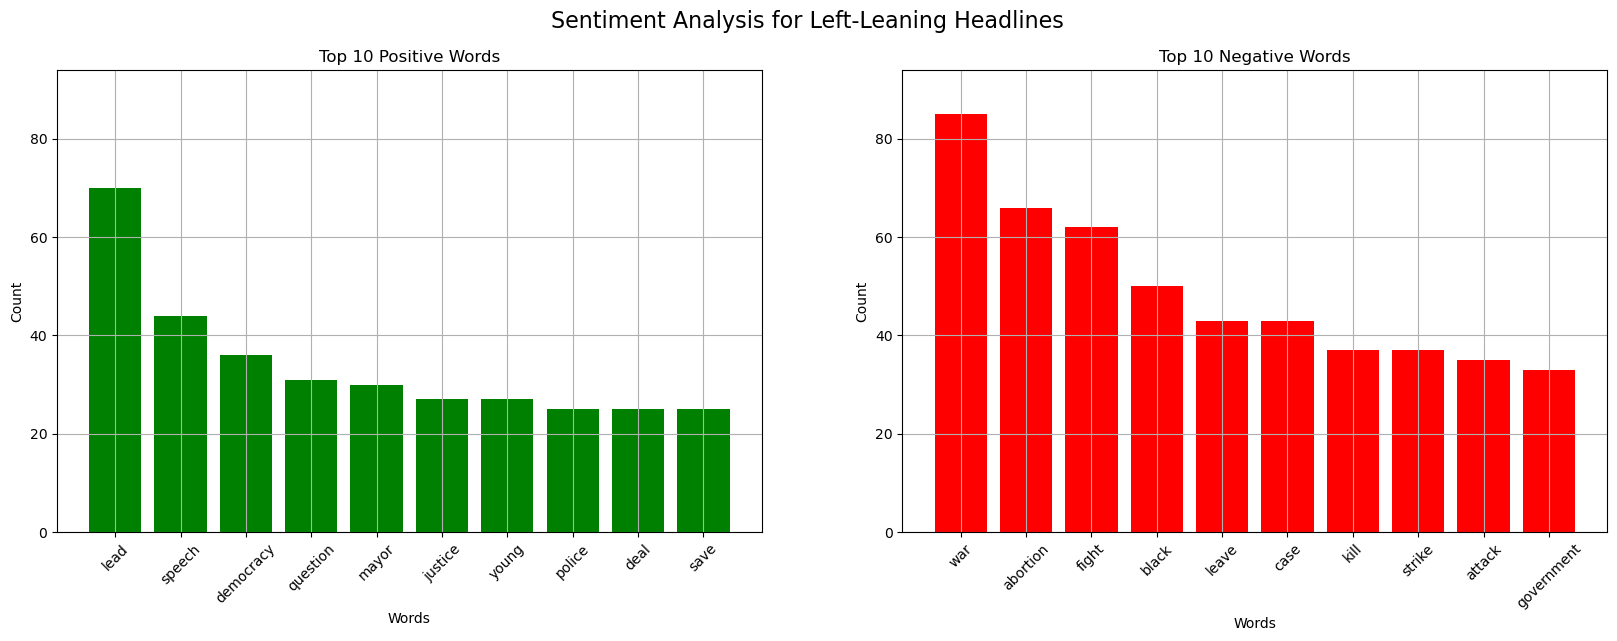

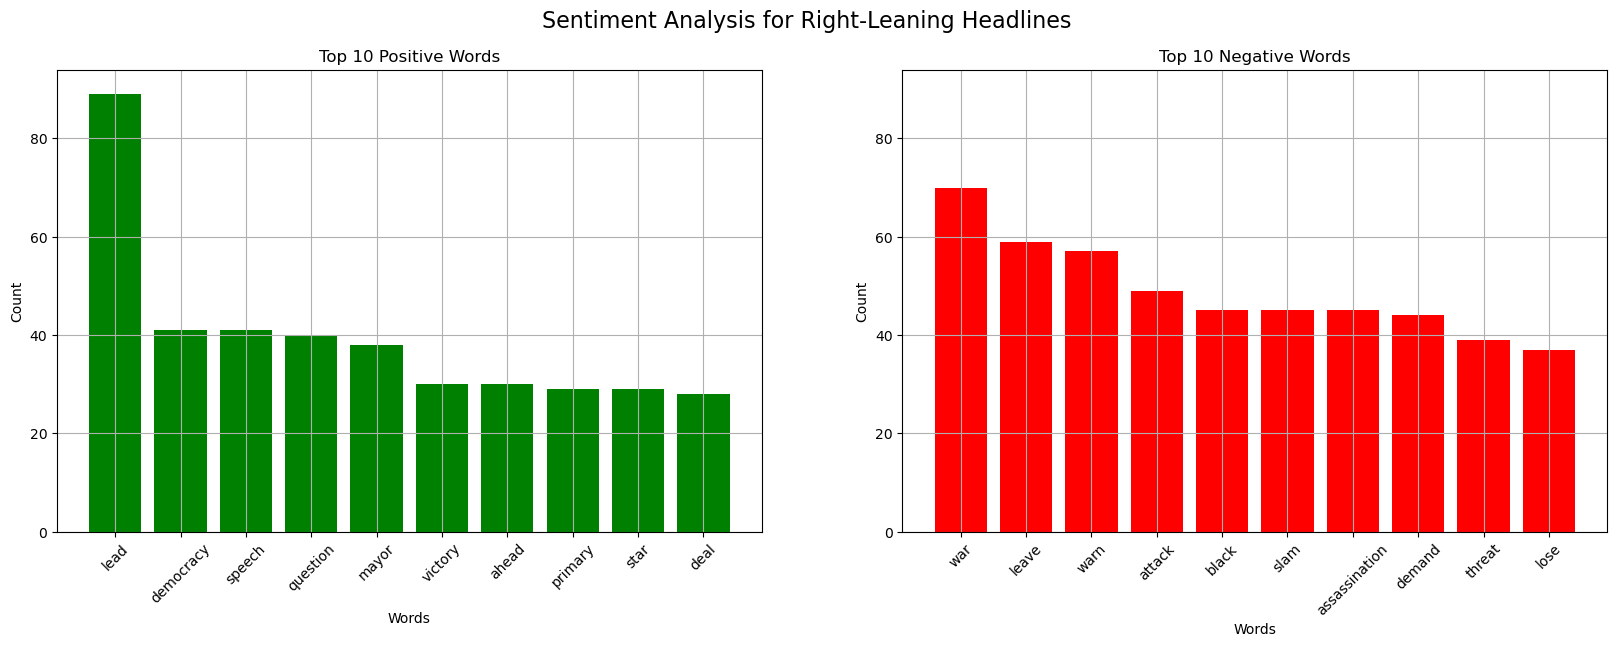

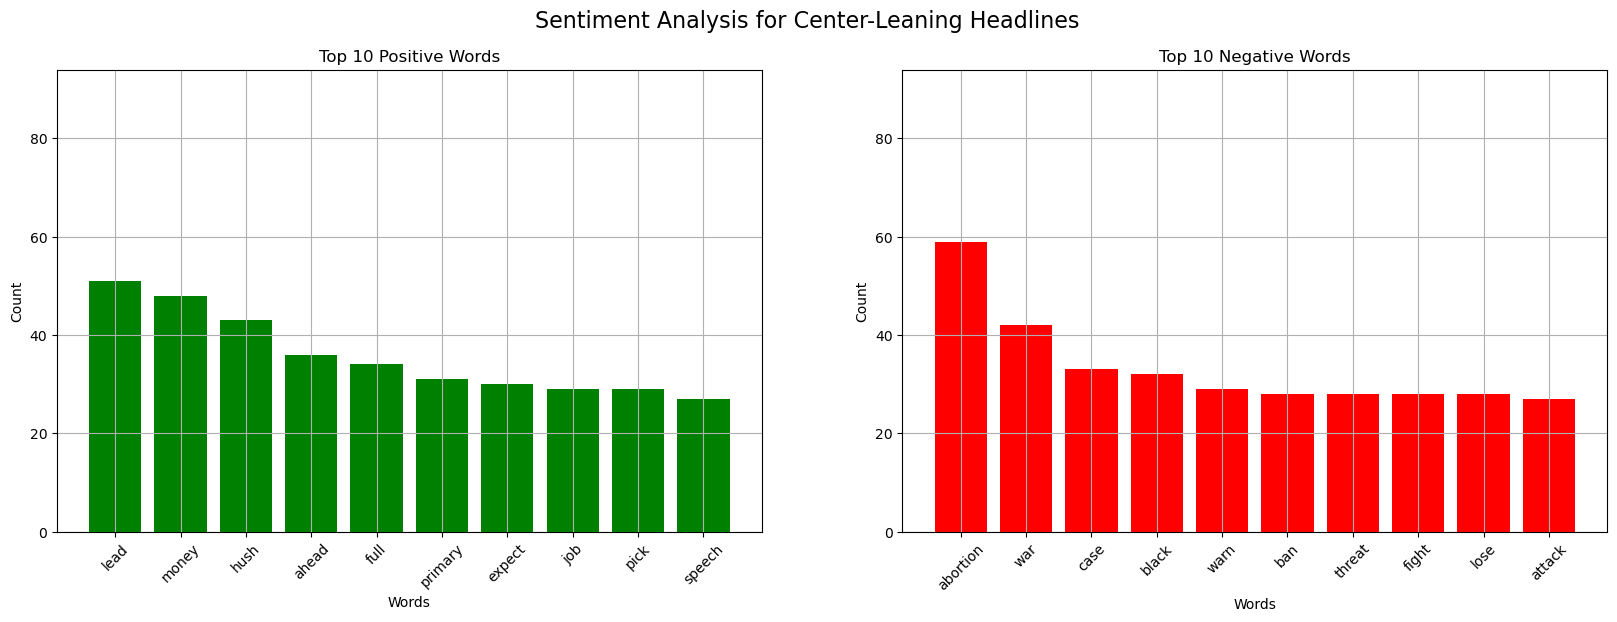

In [384]:
from nrclex import NRCLex
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def get_max_count(df):
    headlines = df['filtered_headline'].str.cat(sep=' ')
    nrc = NRCLex(headlines)
    positive_words = [word for word in nrc.words if 'positive' in nrc.affect_dict.get(word, [])]
    negative_words = [word for word in nrc.words if 'negative' in nrc.affect_dict.get(word, [])]
    pos_counts = Counter(positive_words)
    neg_counts = Counter(negative_words)
    pos_max = max(pos_counts.values()) if pos_counts else 0
    neg_max = max(neg_counts.values()) if neg_counts else 0
    return max(pos_max, neg_max)

# Get a global y-axis maximum across all sentiment dataframes
global_y = max(get_max_count(df_left), get_max_count(df_right), get_max_count(df_center))

def plot_sentiments(df, title, save_filename, y_lim):
    # Combine all headlines from the DataFrame into a single text
    headlines = df['filtered_headline'].str.cat(sep=' ')
    nrc = NRCLex(headlines)
    
    # Get words associated with positive and negative sentiments
    positive_words = [word for word in nrc.words if 'positive' in nrc.affect_dict.get(word, [])]
    negative_words = [word for word in nrc.words if 'negative' in nrc.affect_dict.get(word, [])]
    
    # Count occurrences of positive and negative words
    positive_word_counts = Counter(positive_words)
    negative_word_counts = Counter(negative_words)
    
    # Get the top 10 positive and negative words
    top_positive_words = positive_word_counts.most_common(10)
    top_negative_words = negative_word_counts.most_common(10)
    
    # Create DataFrames for plotting
    positive_df = pd.DataFrame(top_positive_words, columns=['Word', 'Count'])
    negative_df = pd.DataFrame(top_negative_words, columns=['Word', 'Count'])
    
    # Plot the top 10 positive and negative words
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    
    axes[0].bar(positive_df['Word'], positive_df['Count'], color='green')
    axes[0].set_xlabel('Words')
    axes[0].set_ylabel('Count')
    axes[0].set_title("Top 10 Positive Words")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True)
    axes[0].set_ylim(0, y_lim+5)
    
    axes[1].bar(negative_df['Word'], negative_df['Count'], color='red')
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Count')
    axes[1].set_title("Top 10 Negative Words")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True)
    axes[1].set_ylim(0, y_lim+5)
    
    plt.savefig(save_filename, format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot and save figures for left, right, and center
plot_sentiments(df_left, "Sentiment Analysis for Left-Leaning Headlines", "plots/sentiment_word_left.png", global_y)
plot_sentiments(df_right, "Sentiment Analysis for Right-Leaning Headlines", "plots/sentiment_word_right.png", global_y)
plot_sentiments(df_center, "Sentiment Analysis for Center-Leaning Headlines", "plots/sentiment_word_center.png", global_y)

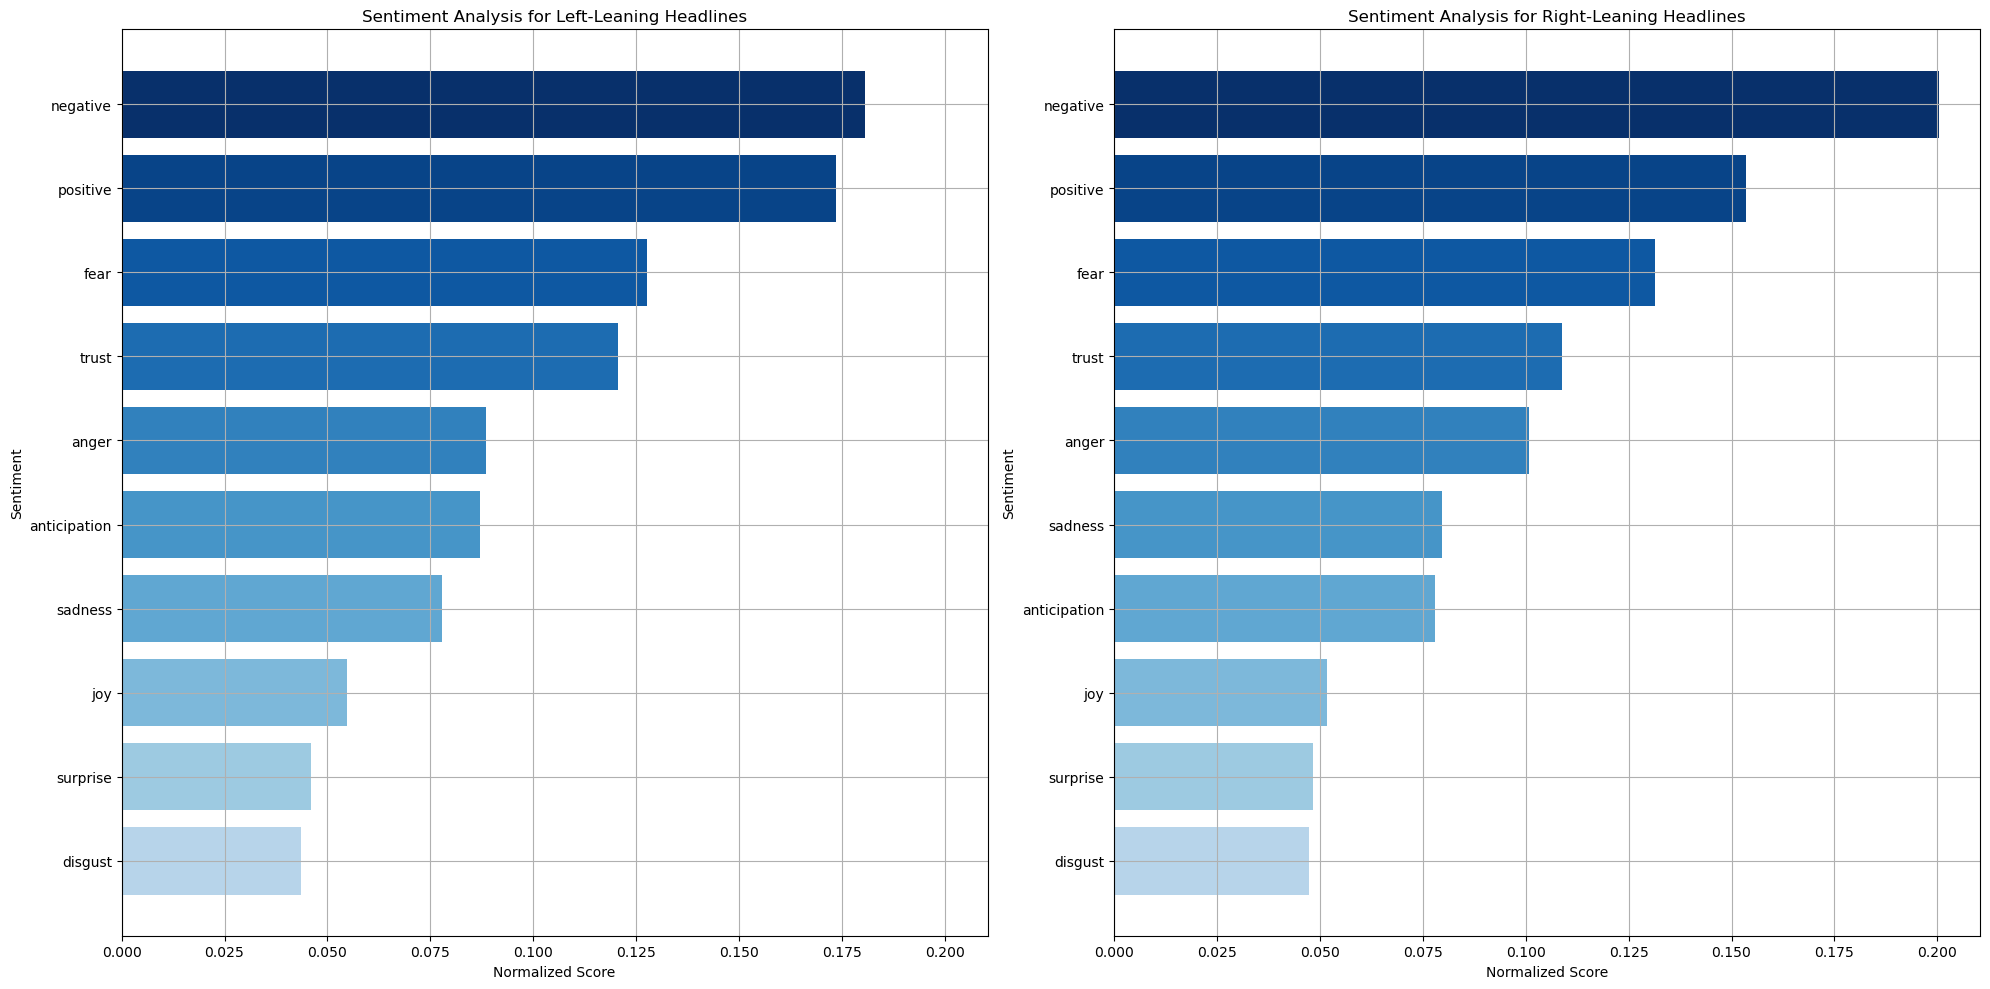

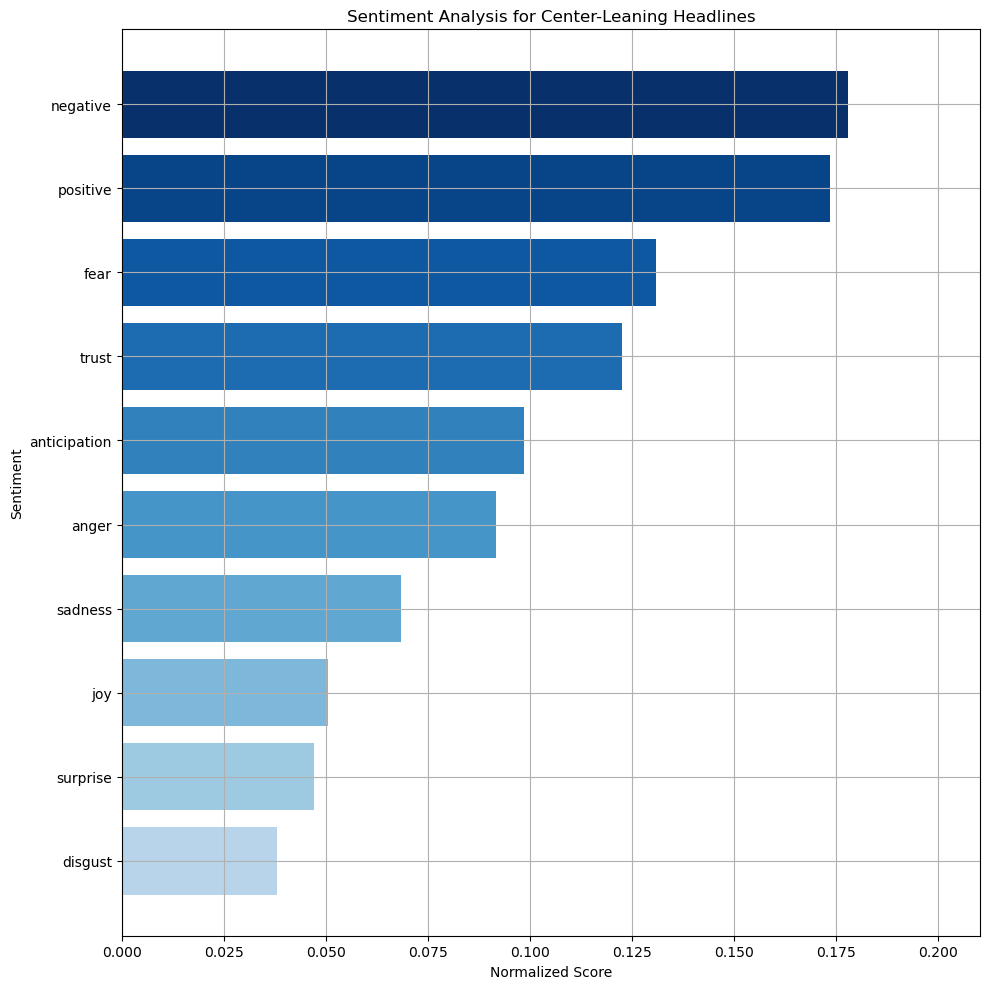

In [385]:
from nrclex import NRCLex
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_sentiments(df, title, ax):
    # Combine all headlines from the DataFrame into a single text
    headlines = df['filtered_headline'].str.cat(sep=' ')

    # Initialize NRC sentiment analyzer
    nrc = NRCLex(headlines)

    # Get sentiment scores
    sentiment_scores = nrc.raw_emotion_scores

    # Normalize sentiment scores
    total_scores = sum(sentiment_scores.values())
    normalized_scores = {emotion: score / total_scores for emotion, score in sentiment_scores.items()}

    # Sort the sentiment scores in descending order
    sorted_scores = dict(sorted(normalized_scores.items(), key=lambda item: item[1], reverse=False))

    # Generate colors from dark to light blue
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_scores)))

    # Plot the sentiment scores as a horizontal bar chart
    ax.barh(list(sorted_scores.keys()), list(sorted_scores.values()), color=colors)
    ax.set_xlabel('Normalized Score')
    ax.set_ylabel('Sentiment')
    ax.set_title(title)
    ax.tick_params(axis='y', rotation=0)
    ax.grid(True)

# Create subplots for left-leaning and right-leaning headlines
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot sentiments for df_left
plot_sentiments(df_left, "Sentiment Analysis for Left-Leaning Headlines", axes[0])

# Plot sentiments for df_right
plot_sentiments(df_right, "Sentiment Analysis for Right-Leaning Headlines", axes[1])

# Ensure the x-axis range is the same for both plots
x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
axes[0].set_xlim(0, x_max)
axes[1].set_xlim(0, x_max)

plt.tight_layout()
plt.savefig("plots/sentimen_left_right.png", format="png", dpi=300, bbox_inches='tight')
plt.show()
# Create a separate plot for center-leaning headlines
fig, ax = plt.subplots(figsize=(10, 10))

# Plot sentiments for df_center
plot_sentiments(df_center, "Sentiment Analysis for Center-Leaning Headlines", ax)

# Ensure the x-axis range is the same as the previous plots
ax.set_xlim(0, x_max)

plt.tight_layout()
plt.savefig("plots/sentimen_center.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## Sentiment trend

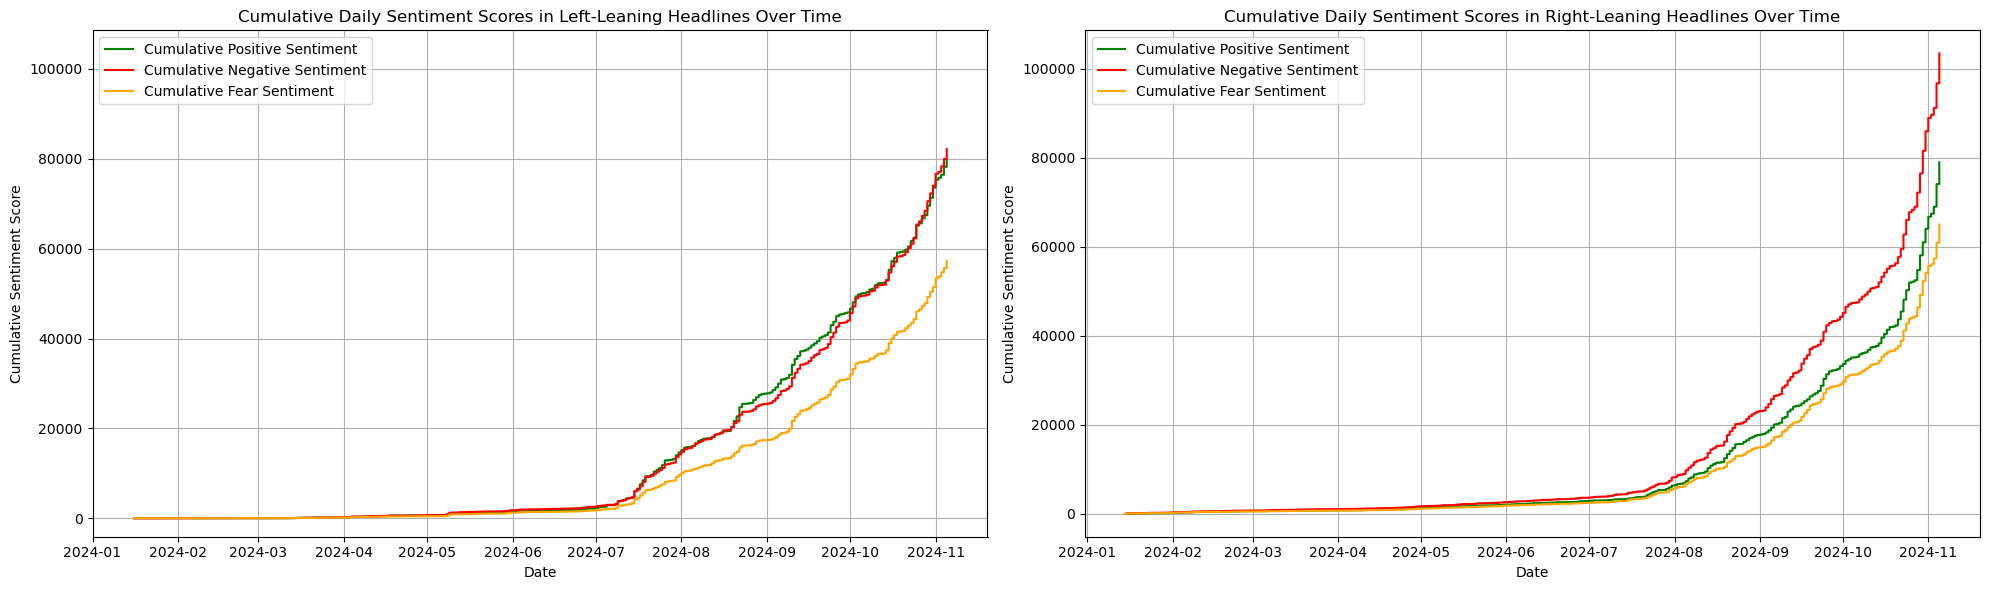

In [502]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nrclex import NRCLex
import matplotlib.pyplot as plt

# Function to calculate cumulative daily sentiment scores
def calculate_cumulative_daily_sentiments(df):
    dates = df.index.date
    daily_sentiments = {'positive': [], 'negative': [], 'anticipation': [], 'fear': []}
    cumulative_positive = 0
    cumulative_negative = 0
    cumulative_anticipation = 0
    cumulative_fear = 0
    
    for date in dates:
        daily_headlines = df[df.index.date == date]['filtered_headline'].str.cat(sep=' ')
        nrc = NRCLex(daily_headlines)
        sentiment_scores = nrc.raw_emotion_scores
        
        cumulative_positive += sentiment_scores.get('positive', 0)
        cumulative_negative += sentiment_scores.get('negative', 0)
        cumulative_anticipation += sentiment_scores.get('anticipation', 0)
        cumulative_fear += sentiment_scores.get('fear', 0)
        
        daily_sentiments['positive'].append(cumulative_positive)
        daily_sentiments['negative'].append(cumulative_negative)
        daily_sentiments['anticipation'].append(cumulative_anticipation)
        daily_sentiments['fear'].append(cumulative_fear)
    
    return dates, daily_sentiments

# Calculate cumulative daily sentiment scores for left-leaning headlines
dates_left, daily_sentiments_left = calculate_cumulative_daily_sentiments(df_left)

# Calculate cumulative daily sentiment scores for right-leaning headlines
dates_right, daily_sentiments_right = calculate_cumulative_daily_sentiments(df_right)

# Plot the cumulative daily sentiment scores over time
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for left-leaning headlines
axes[0].plot(dates_left, daily_sentiments_left['positive'], label='Cumulative Positive Sentiment', color='green')
axes[0].plot(dates_left, daily_sentiments_left['negative'], label='Cumulative Negative Sentiment', color='red')
# axes[0].plot(dates_left, daily_sentiments_left['anticipation'], label='Cumulative Anticipation Sentiment', color='blue')
axes[0].plot(dates_left, daily_sentiments_left['fear'], label='Cumulative Fear Sentiment', color='orange')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Sentiment Score')
axes[0].set_title('Cumulative Daily Sentiment Scores in Left-Leaning Headlines Over Time')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Set x-axis limits to start from January
axes[0].set_xlim(pd.Timestamp('2024-01-01'), dates_left[-1])

# Plot for right-leaning headlines
axes[1].plot(dates_right, daily_sentiments_right['positive'], label='Cumulative Positive Sentiment', color='green')
axes[1].plot(dates_right, daily_sentiments_right['negative'], label='Cumulative Negative Sentiment', color='red')
# axes[1].plot(dates_right, daily_sentiments_right['anticipation'], label='Cumulative Anticipation Sentiment', color='blue')
axes[1].plot(dates_right, daily_sentiments_right['fear'], label='Cumulative Fear Sentiment', color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Sentiment Score')
axes[1].set_title('Cumulative Daily Sentiment Scores in Right-Leaning Headlines Over Time')
axes[1].legend()
axes[1].grid(True)

# Ensure the x-axis and y-axis ranges are the same for both plots
x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_xlim(axes[0].get_xlim()[0], x_max)
axes[1].set_xlim(axes[1].get_xlim()[0], x_max)
axes[0].set_ylim(axes[0].get_ylim()[0], y_max)
axes[1].set_ylim(axes[1].get_ylim()[0], y_max)

plt.tight_layout()
plt.savefig("plots/acumulated_sentiment.png", format="png", dpi=300, bbox_inches='tight')
plt.show()


## Bigram

# LDA

In [ ]:
# import lda
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer

# # Function to filter headlines based on topics of interest
# def filter_headlines(df):
#     return df

# # Filter headlines for df_left and df_right
# filtered_left_headlines = filter_headlines(df_left)
# filtered_center_headlines = filter_headlines(df_center)
# filtered_right_headlines = filter_headlines(df_right)

# # Tokenize and preprocess the text
# stop_words = set(stopwords.words('english'))
# def preprocess_text(headlines):
#     tokens = [word_tokenize(headline) for headline in headlines]
#     tokens = [[word for word in token if word.isalpha() and word.lower() not in stop_words] for token in tokens]
#     return tokens

# left_tokens = preprocess_text(filtered_left_headlines['headline'])
# center_tokens = preprocess_text(filtered_center_headlines['headline'])
# right_tokens = preprocess_text(filtered_right_headlines['headline'])
# print("Left Tokens:", left_tokens[:20])
# print("Right Tokens:", right_tokens[:20])
# # Convert tokens to strings for CountVectorizer
# left_texts = [' '.join(tokens) for tokens in left_tokens]
# right_texts = [' '.join(tokens) for tokens in right_tokens]
# print("Left Texts:", left_texts[:2])
# print("Right Texts:", right_texts[:2])


In [ ]:
# import lda
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import spacy

# # Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')

# # Initialize stopwords
# # stop_words = set(stopwords.words('english'))
# custom_stopwords = set(stopwords.words("english")).union({
#     # "slot", "form", "store", "basis", "digest", "projected", "say", "vote", "america", "american", "politic", "politics", "political", "politician", "voting", "voters", "voter", "presidential", "election", "debate", "campaign", "nation", "national", "people", "state", "president", "ballot", "ahead", "candidate", "calls", "case", "deal", "mayor", 'say', 'news', 'make', 'us', 'report','day', 'week', 'month', 'year', 'time', 'election', 'u', 'one', 'political', 'would', 'like', 'president', 'state', 'presidential', 'win', 'national', 'campaign', 'nation', 'people', 'america', 'go', 'poll', 'take', 'back', 'debate', 'say', 'see'
#     'slot'
# })

# # Load the spaCy model
# nlp = spacy.load("en_core_web_sm")

# # Function to preprocess text
# def preprocess_text(headlines):
#     preprocessed_headlines = []
#     for headline in headlines:
#         # Tokenize the text
#         tokens = word_tokenize(headline)
        
#         # Filter and lemmatize tokens using spaCy
#         filtered_tokens = [
#             token.lemma_.lower()  # Lemmatize the word
#             for token in nlp(' '.join(tokens))
#             if token.is_alpha and token.text.lower() not in custom_stopwords  # Exclude stopwords and non-alphabetic tokens
#         ]
        
#         # Apply synonym mapping
#         synonym_map = {
#             "politics": "politic",
#             "political": "politic",
#             "politician": "politic",
#             'american' : 'america',
#             'voting' : 'vote',
#             'voters' : 'vote',
#             'voter' : 'vote',
#         }
#         filtered_tokens = [synonym_map.get(token, token) for token in filtered_tokens]
        
#         preprocessed_headlines.append(filtered_tokens)
    
#     return preprocessed_headlines

# # Preprocess left and right headlines
# left_tokens = preprocess_text(df_left['headline'])
# right_tokens = preprocess_text(df_right['headline'])

# # Print some lemmatized tokens
# print("Left Tokens:", left_tokens[:2])
# print("Right Tokens:", right_tokens[:2])


## Try filtering TF-idf

In [402]:
left_texts = list(left_tokens)
center_texts = list(center_tokens)
right_texts = list(right_tokens)

# Convert custom_stopwords set to a list
custom_stopwords_list = list(custom_stopwords)

# Compute TF-IDF after synonym mapping
vectorizer_left = TfidfVectorizer(stop_words=custom_stopwords_list, max_df=0.90, min_df=2)
vectorizer_center = TfidfVectorizer(stop_words=custom_stopwords_list, max_df=0.9, min_df=2)
vectorizer_right = TfidfVectorizer(stop_words=custom_stopwords_list, max_df=0.9, min_df=2)

tfidf_matrix_left = vectorizer_left.fit_transform(left_texts)
tfidf_matrix_center = vectorizer_center.fit_transform(center_texts)
tfidf_matrix_right = vectorizer_right.fit_transform(right_texts)

# Create filtered_text columns based on vectorizer
df_left['filtered_text'] = [' '.join([word for word in text.split() if word in vectorizer_left.get_feature_names_out()]) for text in left_texts]
df_center['filtered_text'] = [' '.join([word for word in text.split() if word in vectorizer_center.get_feature_names_out()]) for text in center_texts]
df_right['filtered_text'] = [' '.join([word for word in text.split() if word in vectorizer_right.get_feature_names_out()]) for text in right_texts]

# Get feature names (words) separately for left and right
if tfidf_matrix_left.shape[1] > 0:
    feature_names_left = vectorizer_left.get_feature_names_out()
    tfidf_df_left = pd.DataFrame(tfidf_matrix_left.toarray(), columns=feature_names_left)
else:
    print("Warning: No features extracted from left dataset.")

if tfidf_matrix_center.shape[1] > 0:
    feature_names_center = vectorizer_center.get_feature_names_out()
    tfidf_df_center = pd.DataFrame(tfidf_matrix_center.toarray(), columns=feature_names_center)
else:
    print("Warning: No features extracted from center dataset.")

if tfidf_matrix_right.shape[1] > 0:
    feature_names_right = vectorizer_right.get_feature_names_out()
    tfidf_df_right = pd.DataFrame(tfidf_matrix_right.toarray(), columns=feature_names_right)
else:
    print("Warning: No features extracted from right dataset.")


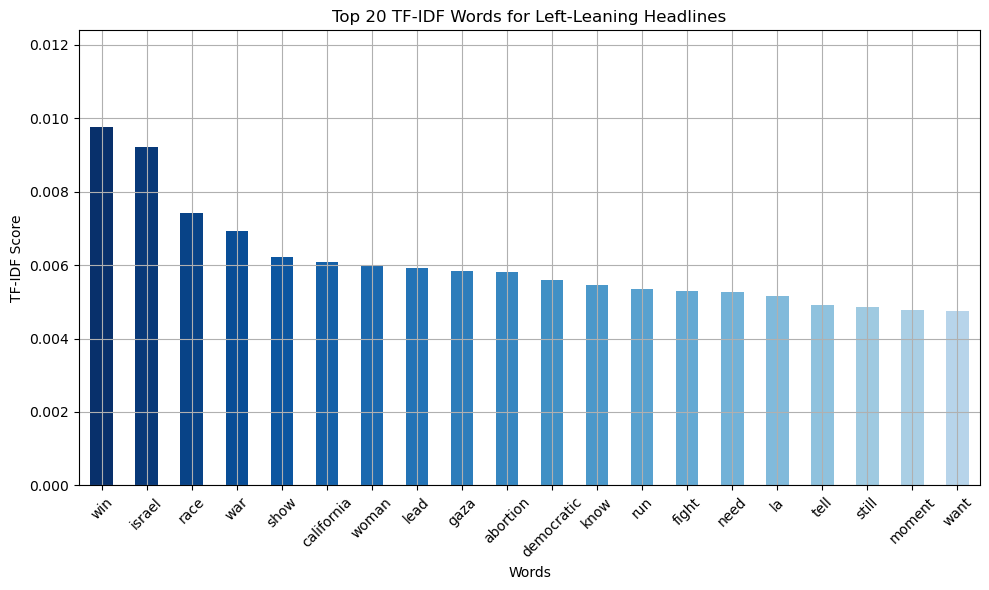

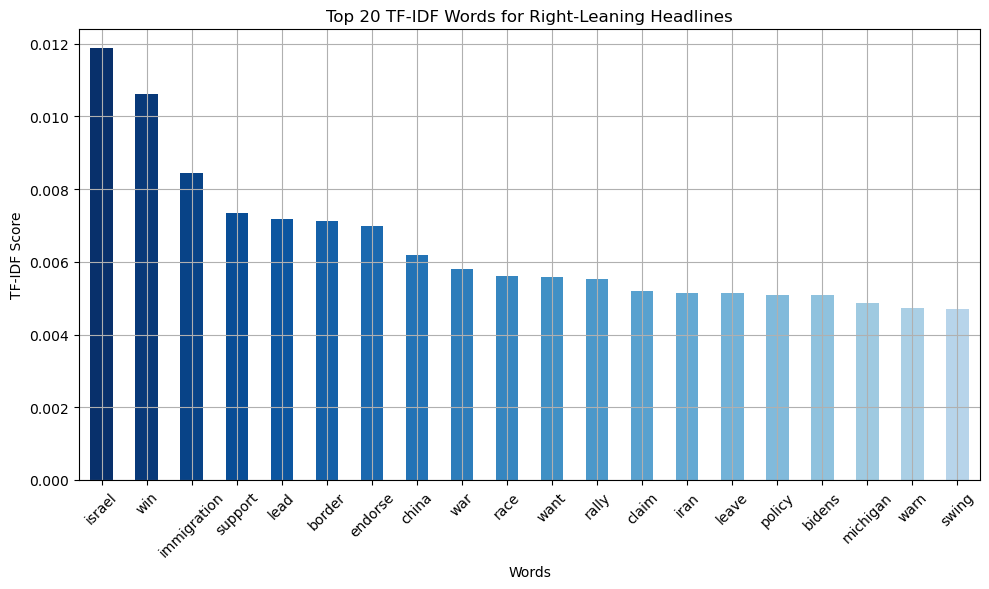

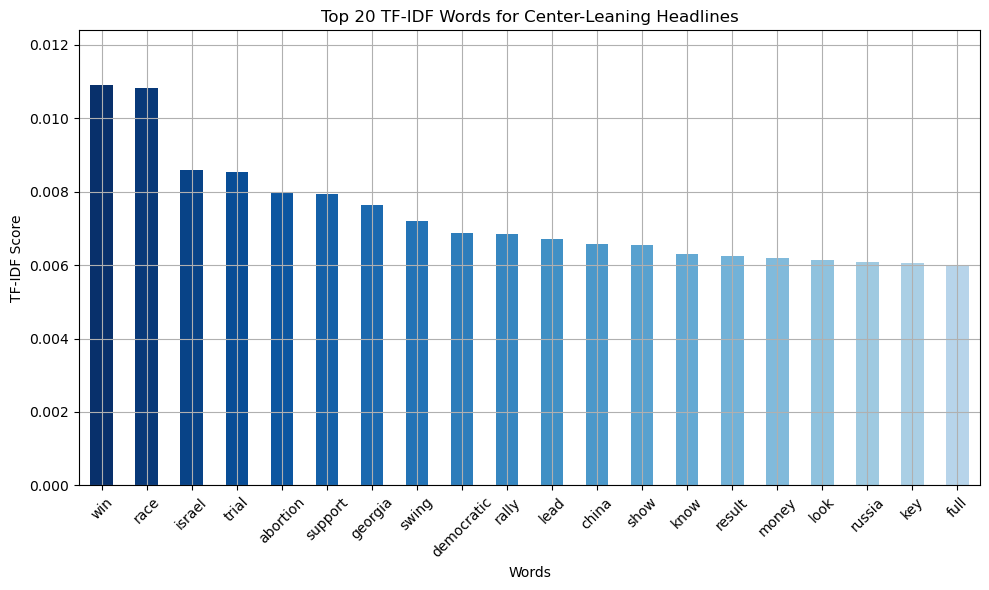

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot top 20 TF-IDF words
def plot_top_tfidf_words(tfidf_df, title, save_filename, y_lim):
    top_20_words = tfidf_df.mean().sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_20_words)))
    top_20_words.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('TF-IDF Score')
    plt.ylim(0, y_lim)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_filename, format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Calculate the global y-axis limit
y_lim = max(tfidf_df_left.mean().max(), tfidf_df_right.mean().max(), tfidf_df_center.mean().max())

# Plot top 20 TF-IDF words for df_left
plot_top_tfidf_words(tfidf_df_left, "Top 20 TF-IDF Words for Left-Leaning Headlines", "plots/tf-idf_left.png", y_lim+0.0005)

# Plot top 20 TF-IDF words for df_right
plot_top_tfidf_words(tfidf_df_right, "Top 20 TF-IDF Words for Right-Leaning Headlines", "plots/tf-idf_right.png", y_lim+0.0005)

# Plot top 20 TF-IDF words for df_center
plot_top_tfidf_words(tfidf_df_center, "Top 20 TF-IDF Words for Center-Leaning Headlines", "plots/tf-idf_center.png", y_lim+0.0005)


In [36]:
df_left.to_csv("stories_left.csv", index=False)
df_right.to_csv("stories_right.csv", index=False)

In [ ]:
# # Find the ranking of the word "shoot" and its TF-IDF score for df_left
# word = "gender"
# if word in tfidf_df_left.columns:
#     word_index_left = tfidf_df_left.columns.get_loc(word)
#     word_tfidf_left = tfidf_means_left[word_index_left]
#     word_ranking_left = np.argsort(tfidf_means_left)[::-1].tolist().index(word_index_left) + 1
#     print(f"The word '{word}' has a TF-IDF score of {word_tfidf_left} and is ranked {word_ranking_left} among all words in df_left.")
# else:
#     print(f"The word '{word}' is not present in df_left.")

# # Find the ranking of the word "shoot" and its TF-IDF score for df_right
# if word in tfidf_df_right.columns:
#     word_index_right = tfidf_df_right.columns.get_loc(word)
#     word_tfidf_right = tfidf_means_right[word_index_right]
#     word_ranking_right = np.argsort(tfidf_means_right)[::-1].tolist().index(word_index_right) + 1
#     print(f"The word '{word}' has a TF-IDF score of {word_tfidf_right} and is ranked {word_ranking_right} among all words in df_right.")
# else:
#     print(f"The word '{word}' is not present in df_right.")

# # Find the ranking of the word "shoot" and its TF-IDF score for df_center
# if word in tfidf_df_center.columns:
#     word_index_center = tfidf_df_center.columns.get_loc(word)
#     word_tfidf_center = tfidf_means_center[word_index_center]
#     word_ranking_center = np.argsort(tfidf_means_center)[::-1].tolist().index(word_index_center) + 1
#     print(f"The word '{word}' has a TF-IDF score of {word_tfidf_center} and is ranked {word_ranking_center} among all words in df_center.")
# else:
#     print(f"The word '{word}' is not present in df_center.")

The word 'gender' has a TF-IDF score of 0.0010228252581871093 and is ranked 552 among all words in df_left.
The word 'gender' has a TF-IDF score of 0.000923473560249726 and is ranked 757 among all words in df_right.
The word 'gender' has a TF-IDF score of 0.001619532332288112 and is ranked 363 among all words in df_center.


## Bigram

## Sentiment

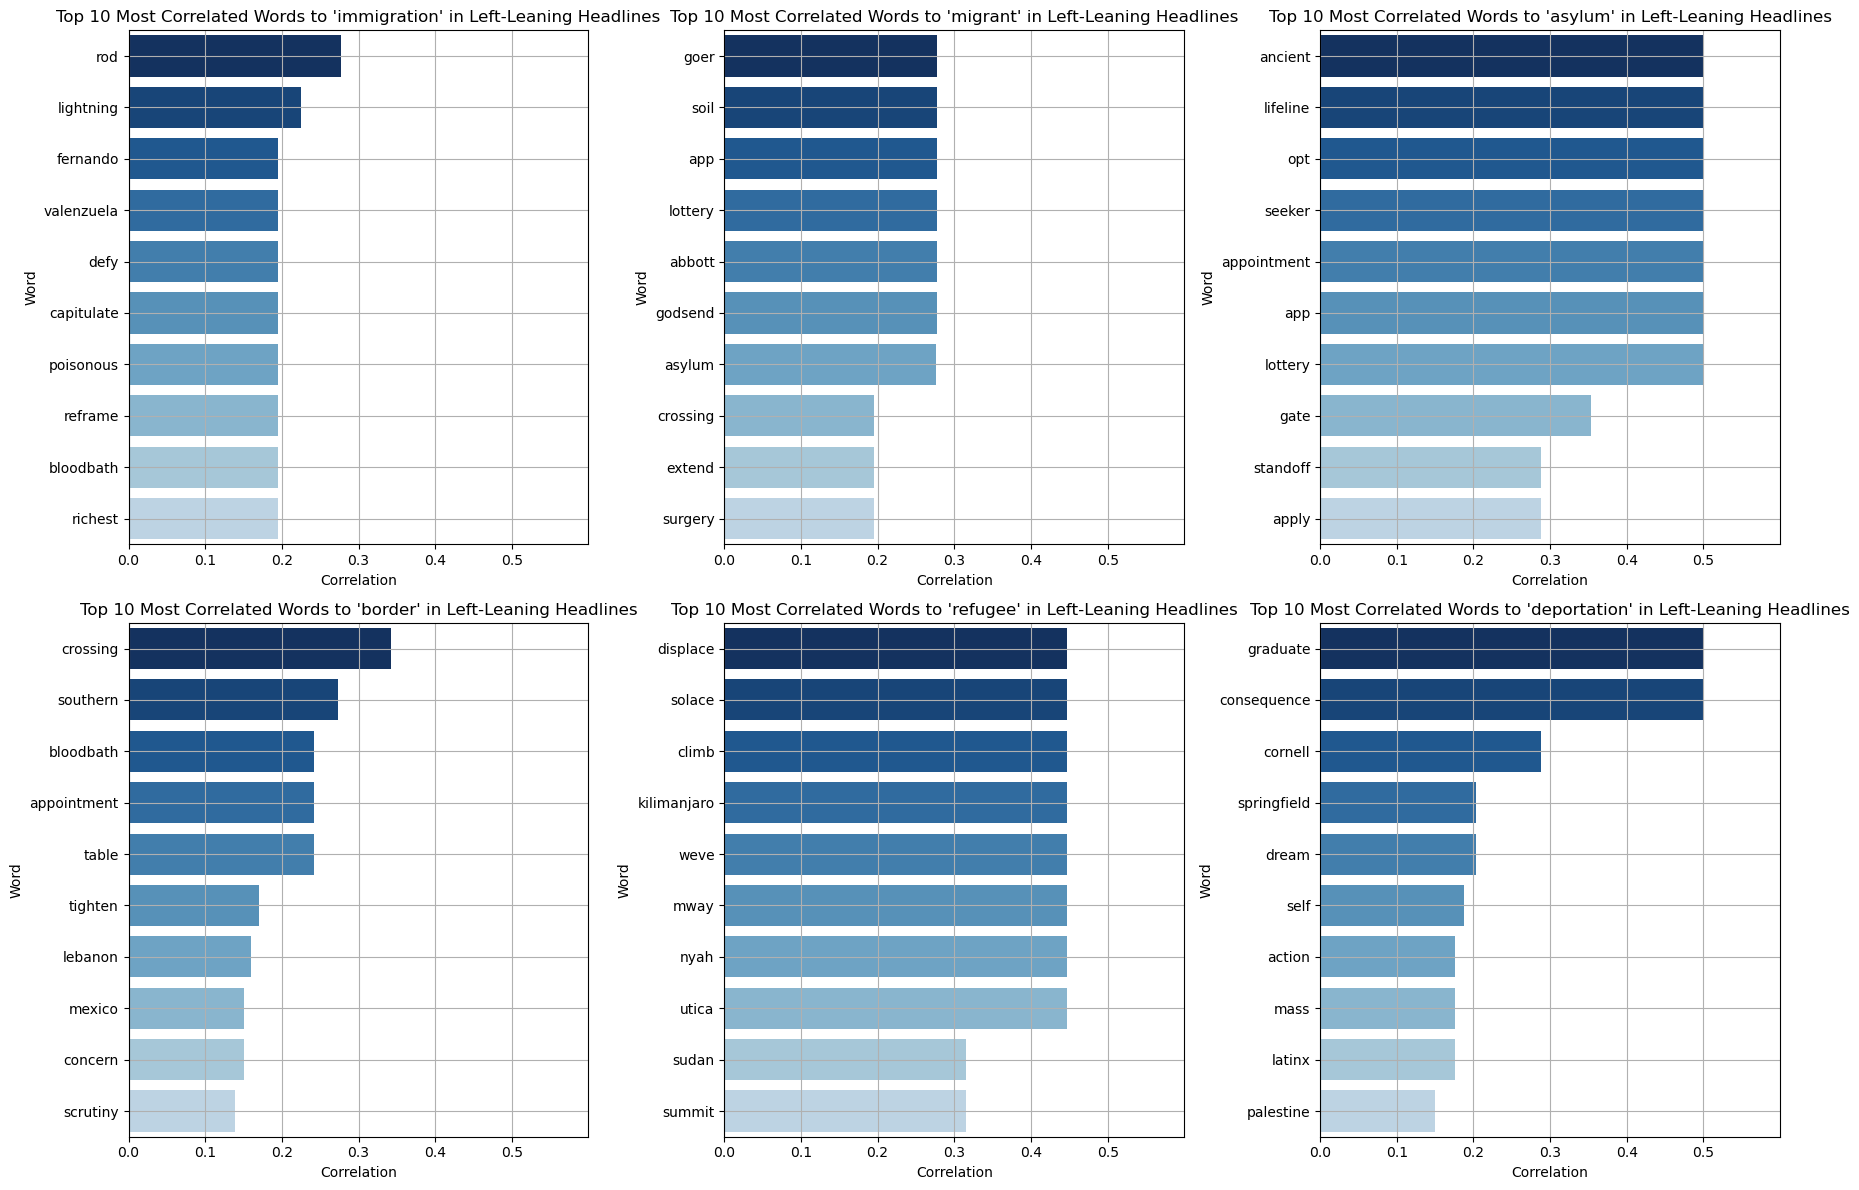

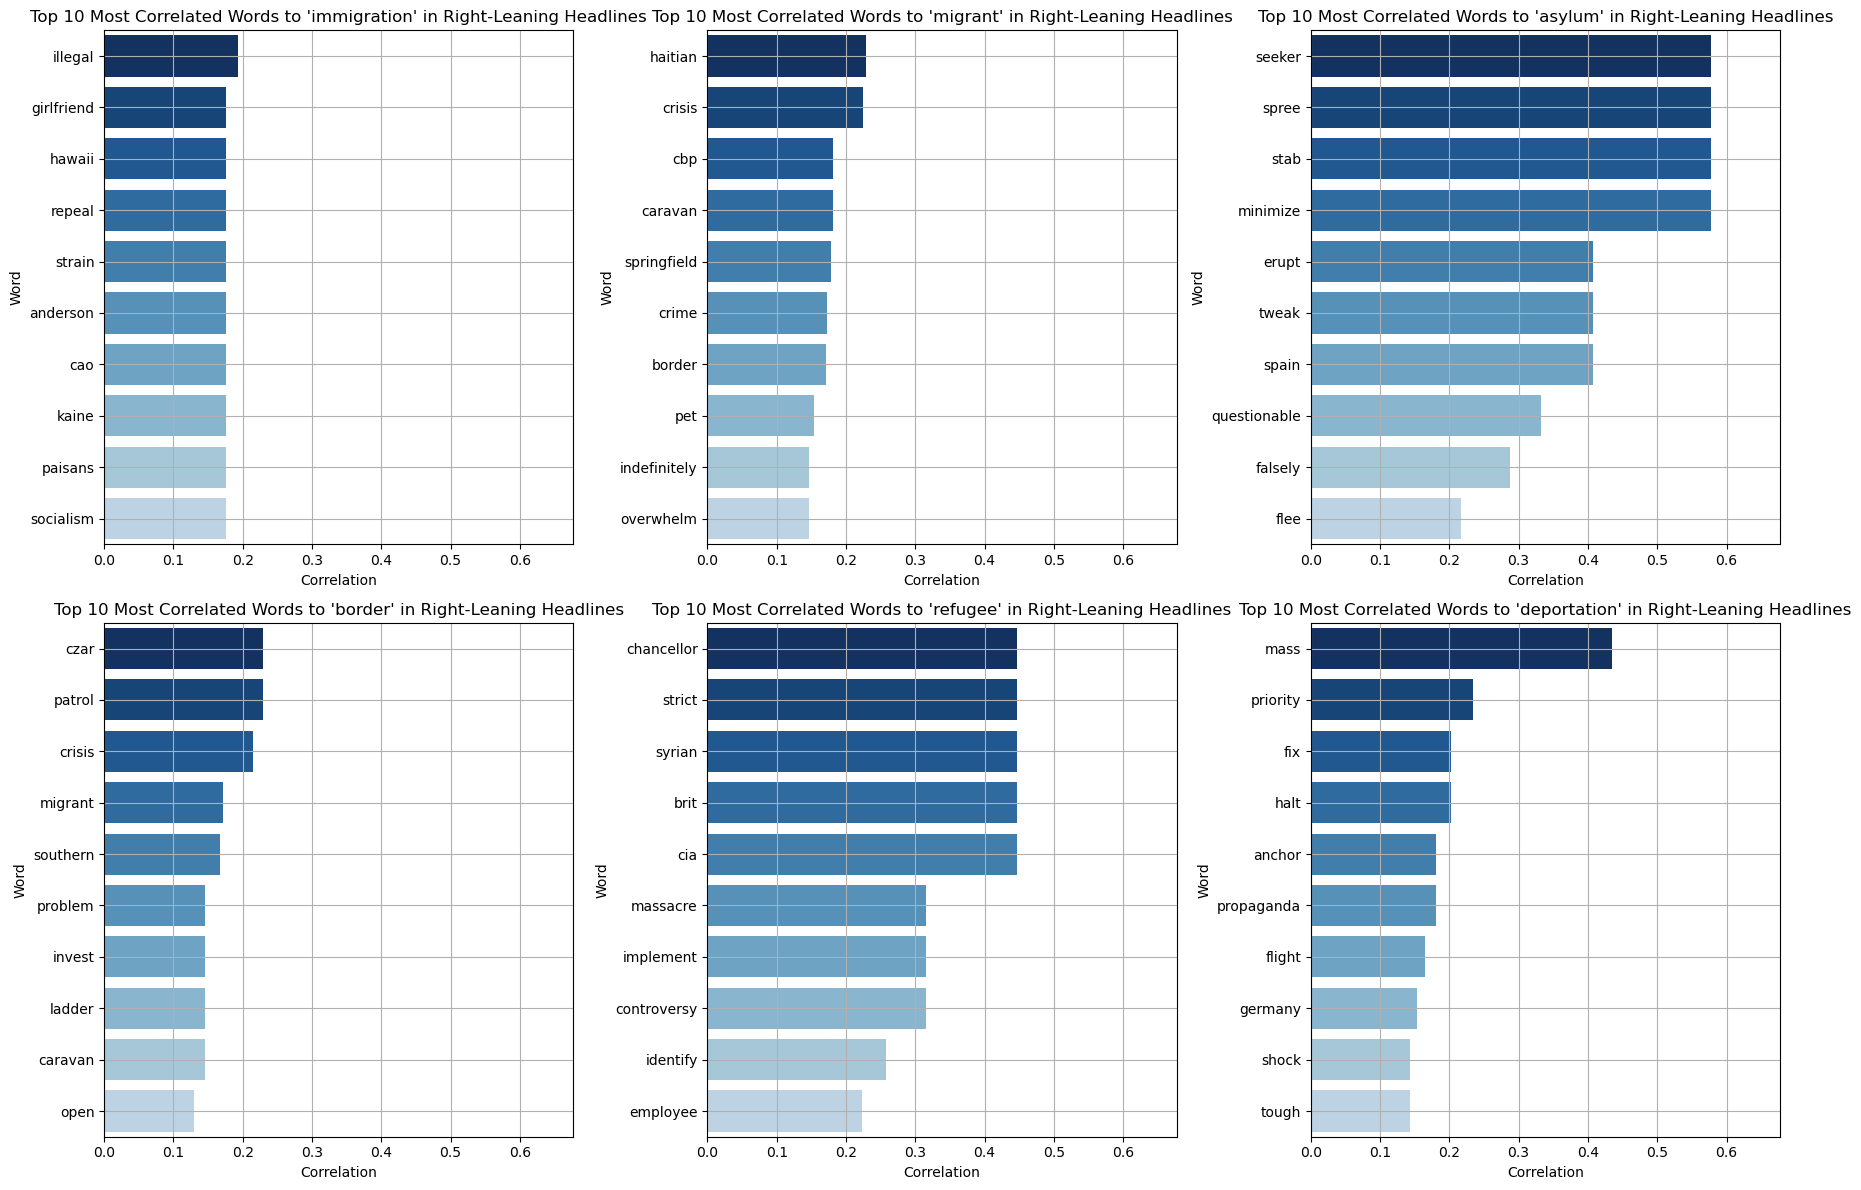

In [466]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import warnings

# Turn off warnings
warnings.filterwarnings('ignore')

def plot_top_correlated_words(df, key_terms, title_prefix):
    # Combine all headlines into a single text
    documents = df['filtered_headline_no_synonym'].tolist()

    # Vectorize text using CountVectorizer (Bag-of-Words Model)
    vectorizer = CountVectorizer(stop_words="english")
    X = vectorizer.fit_transform(documents)
    word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Compute correlation of all words with key terms
    correlation_results = []
    for term in key_terms:
        if term in word_freq_df.columns:
            for word in word_freq_df.columns:
                if word != term:  # Avoid self-correlation
                    correlation = np.corrcoef(word_freq_df[term], word_freq_df[word])[0, 1]
                    correlation_results.append({"key_term": term, "word": word, "correlation": correlation})

    # Convert results to DataFrame
    correlation_df = pd.DataFrame(correlation_results)

    # Filter for strongest correlations (top 10 per key term)
    top_words_df = correlation_df.groupby("key_term").apply(lambda x: x.nlargest(10, "correlation")).reset_index(drop=True)

    # Determine the maximum x-axis limit for all plots
    x_max = top_words_df["correlation"].max()

    # Plot for each key term in a 2x3 layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    for i, term in enumerate(key_terms):
        term_df = top_words_df[top_words_df["key_term"] == term]
        colors = plt.cm.Blues(np.linspace(1, 0.3, len(term_df)))  # Generate colors from dark to light blue
        sns.barplot(x="correlation", y="word", data=term_df, palette=colors, ax=axes[i])
        axes[i].set_title(f"Top 10 Most Correlated Words to '{term}' in {title_prefix}")
        axes[i].set_xlabel("Correlation")
        axes[i].set_ylabel("Word")
        axes[i].set_xlim(0, x_max + 0.1)  # Set the range of x-axis to be the same for all plots
        axes[i].grid(True)  # Show grid

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f"plots/correlated_words_{title_prefix.lower().replace(' ', '_')}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Define key terms
key_terms = ["immigration", "migrant", "asylum", "border", "refugee", "deportation"]

# Apply the function to df_left and df_right
plot_top_correlated_words(df_left, key_terms, "Left-Leaning Headlines")
plot_top_correlated_words(df_right, key_terms, "Right-Leaning Headlines")

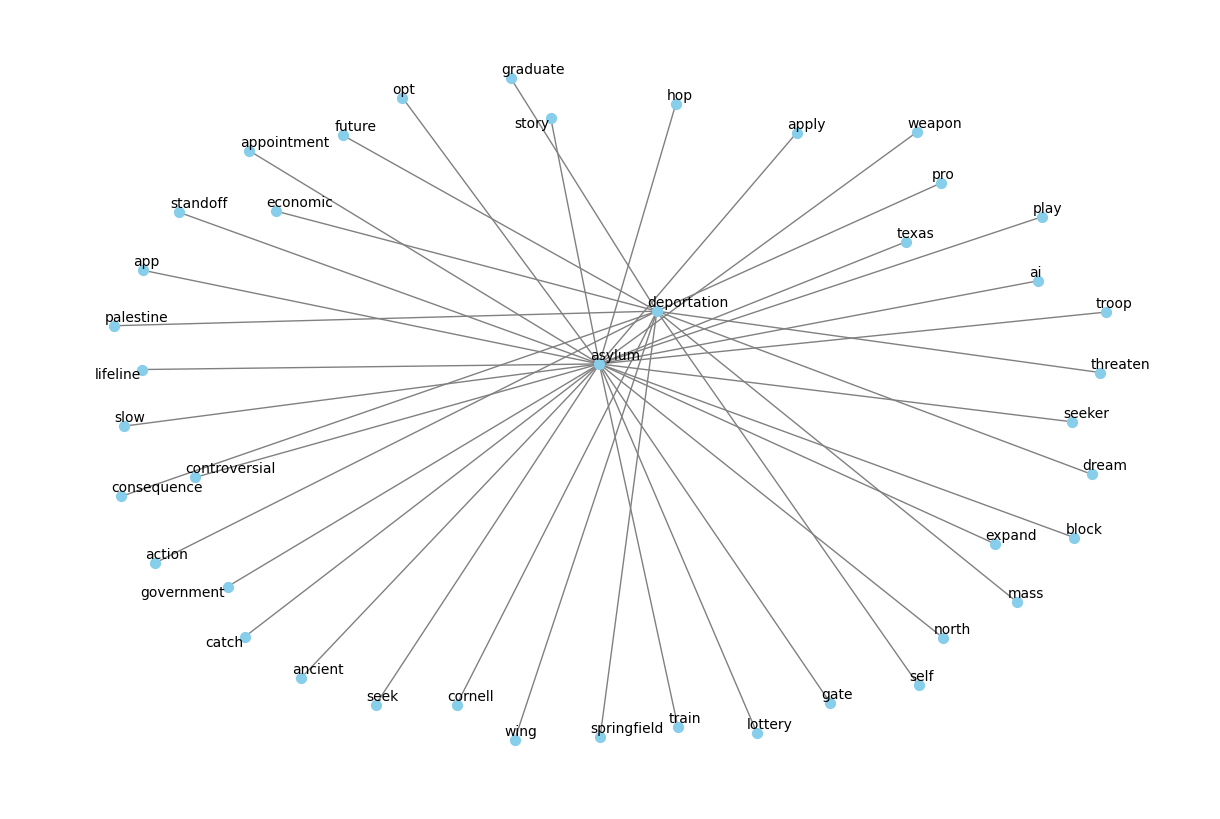

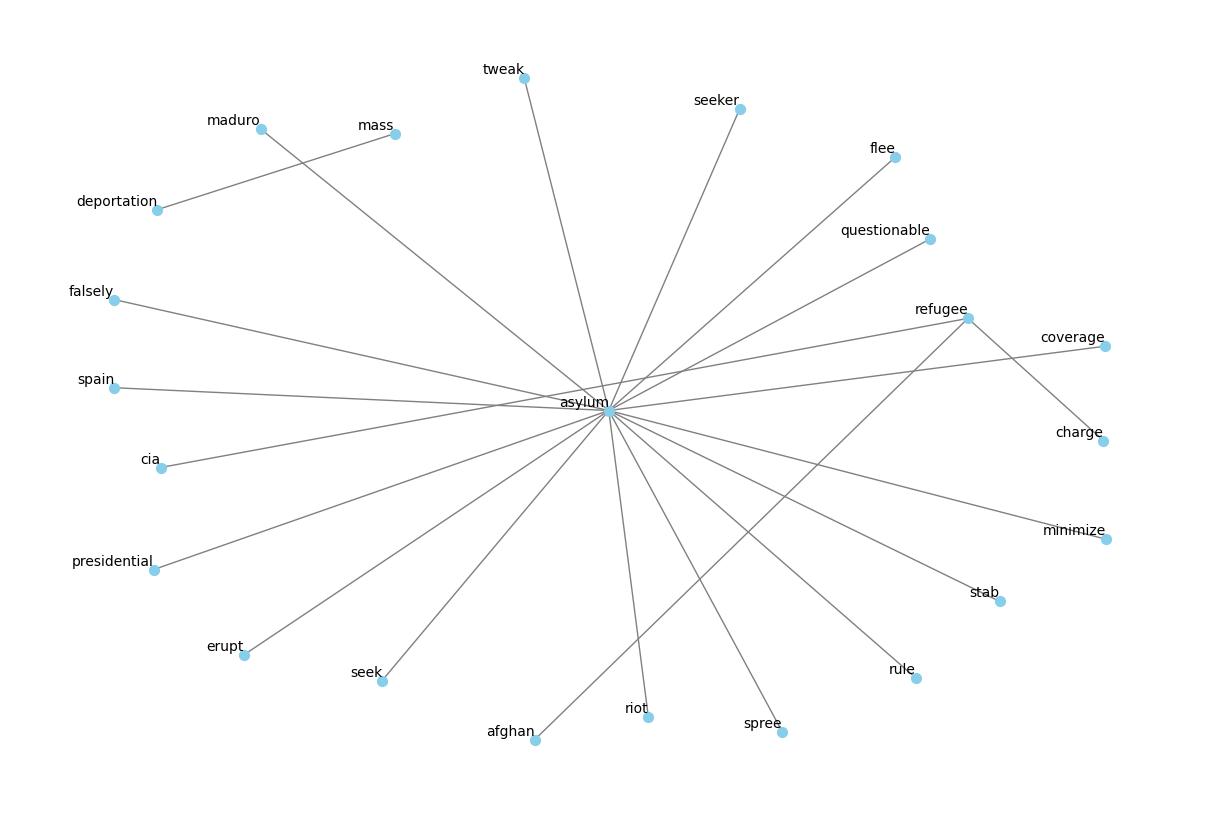

In [503]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Function to filter headlines containing at least one key term
def filter_headlines(df, key_terms):
    return df[df['filtered_headline_no_synonym'].str.contains('|'.join(key_terms), case=False, na=False)]

# Function to compute correlations for filtered headlines
def compute_correlations(filtered_df, key_terms):
    documents = filtered_df['filtered_headline_no_synonym'].tolist()
    vectorizer = CountVectorizer(stop_words="english")
    X = vectorizer.fit_transform(documents)
    word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    correlation_results = []
    for term in key_terms:
        if term in word_freq_df.columns:
            for word in word_freq_df.columns:
                if word != term:
                    correlation = np.corrcoef(word_freq_df[term], word_freq_df[word])[0, 1]
                    correlation_results.append({"key_term": term, "word": word, "correlation": correlation})

    return pd.DataFrame(correlation_results)

# Function to generate and plot a correlation network
def plot_correlation_network(correlation_df, media_label, threshold=0.5):
    G = nx.Graph()

    for _, row in correlation_df.iterrows():
        if row['correlation'] >= threshold:
            G.add_edge(row['key_term'], row['word'], weight=row['correlation'])

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=1.5)
    nx.draw(G, pos, with_labels=False, node_size=50, edge_color="gray", font_size=10, node_color="skyblue")
    
    texts = [plt.text(pos[node][0], pos[node][1], node, fontsize=10, ha='right') for node in G.nodes()]
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    

    plt.savefig(f"plots/correlation_network_{media_label.lower().replace('-', '_')}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Define key terms
key_terms = ["immigration", "migrant", "asylum", "border", "refugee", "deportation"]

# Filter headlines and compute correlations for right-leaning headlines
filtered_right_df = filter_headlines(df_right, key_terms)
correlation_df_right = compute_correlations(filtered_right_df, key_terms)

# Filter headlines and compute correlations for left-leaning headlines
filtered_left_df = filter_headlines(df_left, key_terms)
correlation_df_left = compute_correlations(filtered_left_df, key_terms)

# Plot correlation networks
plot_correlation_network(correlation_df_left, "Left-Leaning", threshold=0.49)
plot_correlation_network(correlation_df_right, "Right-Leaning", threshold=0.49)


[nltk_data] Downloading package punkt to /Users/pc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


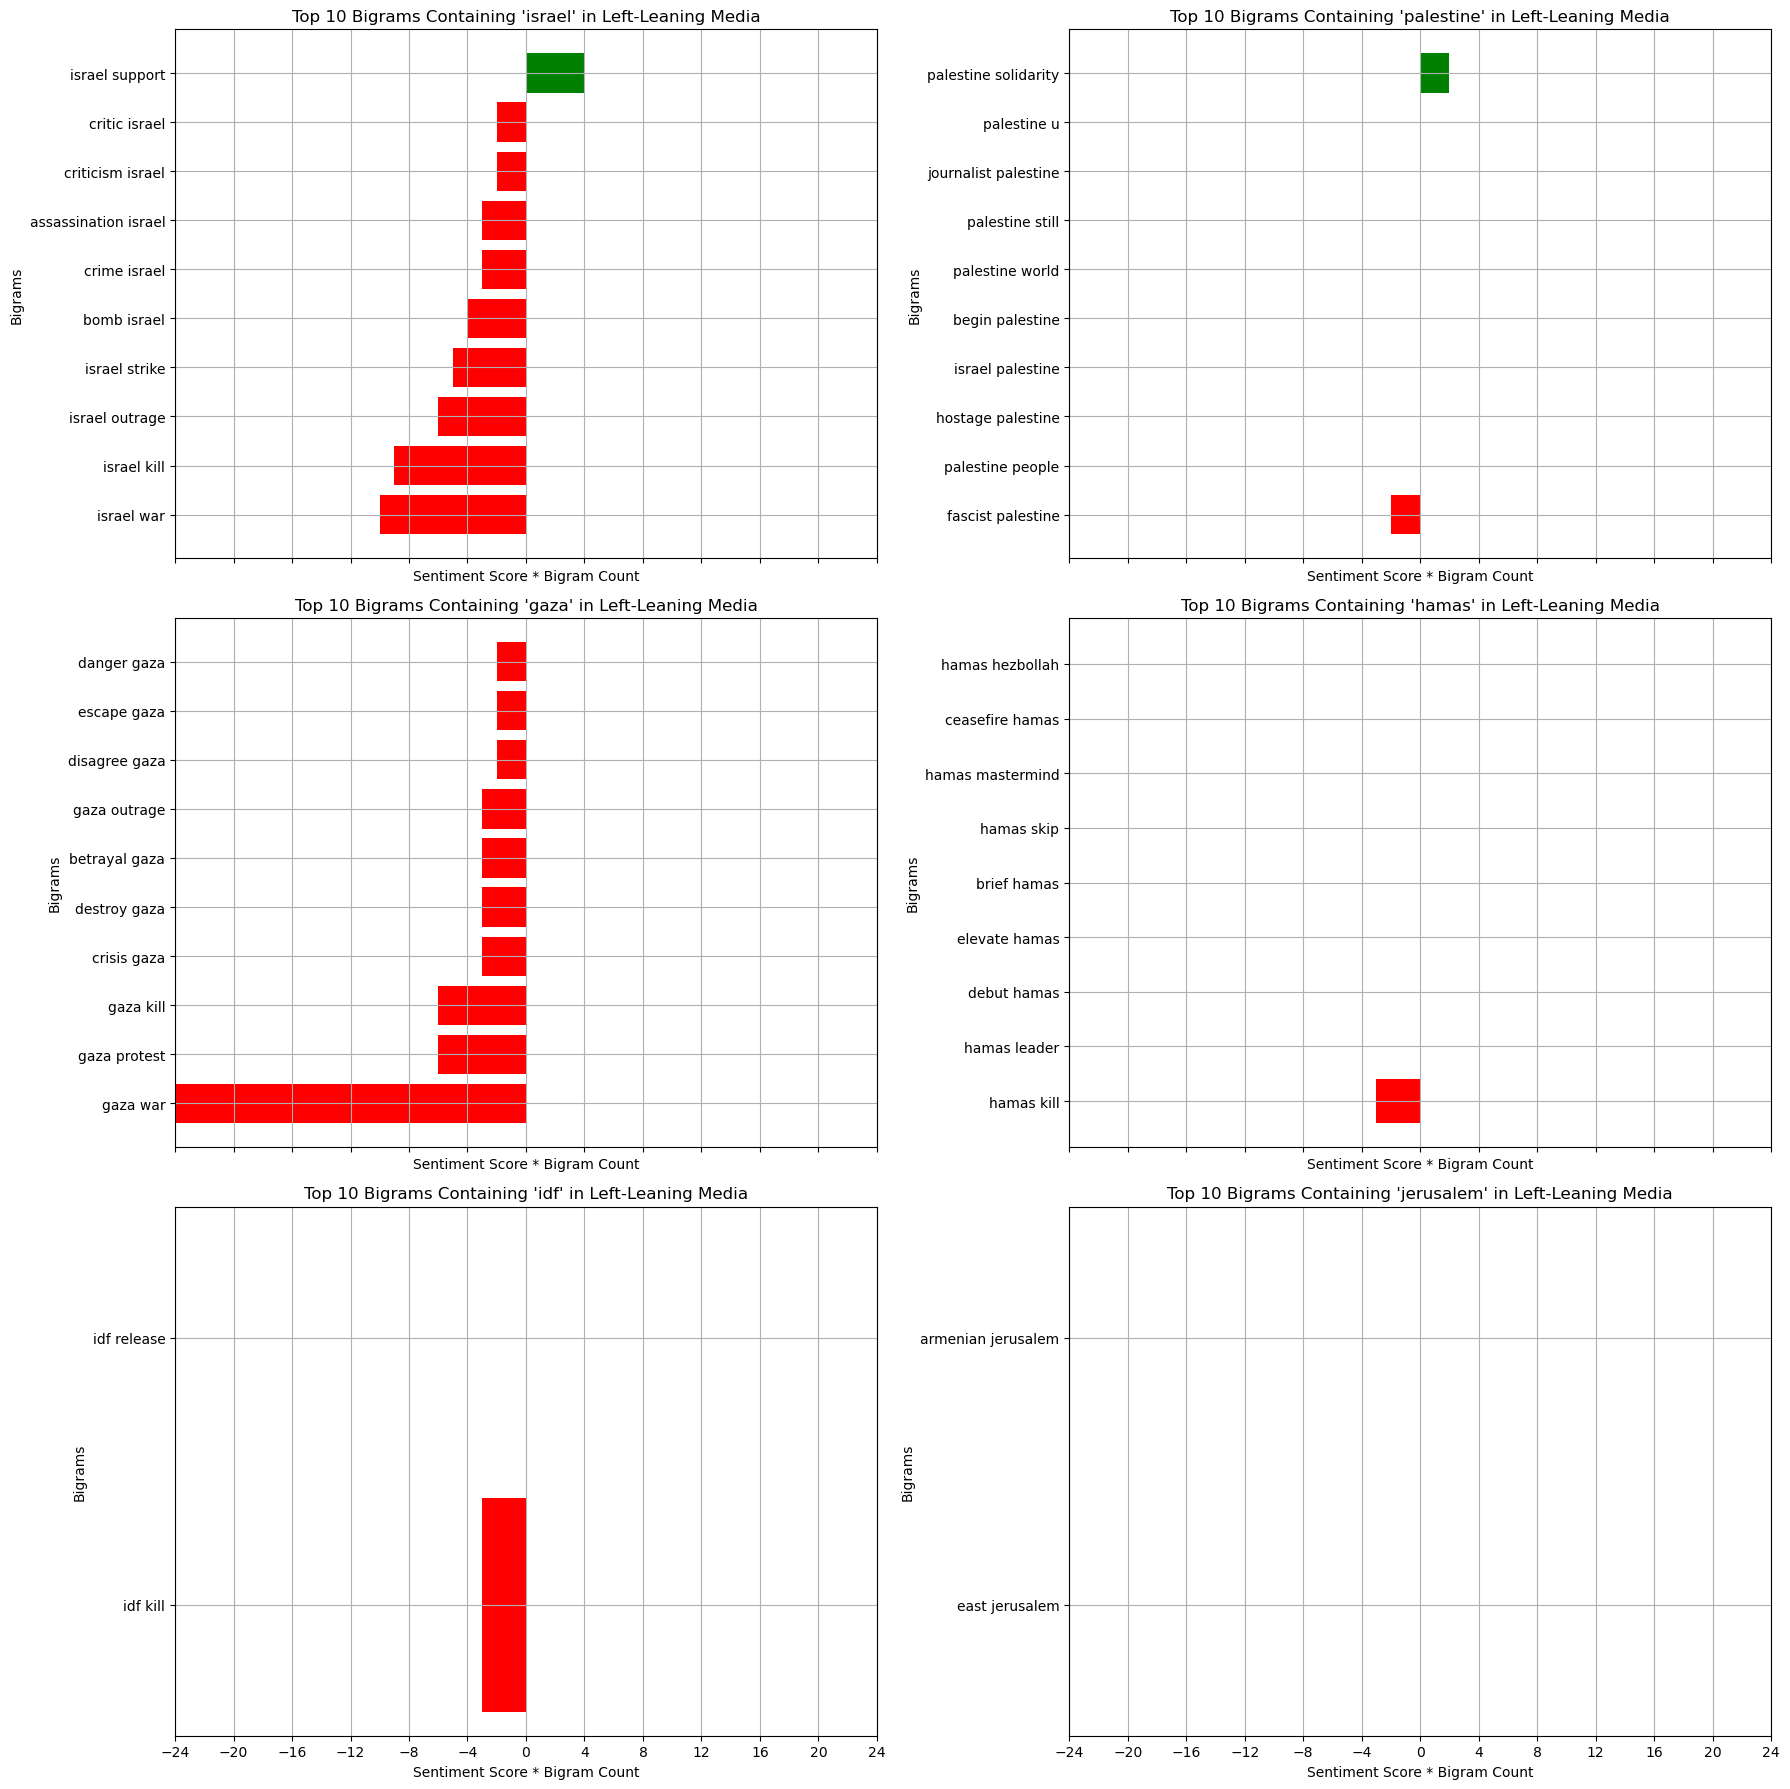

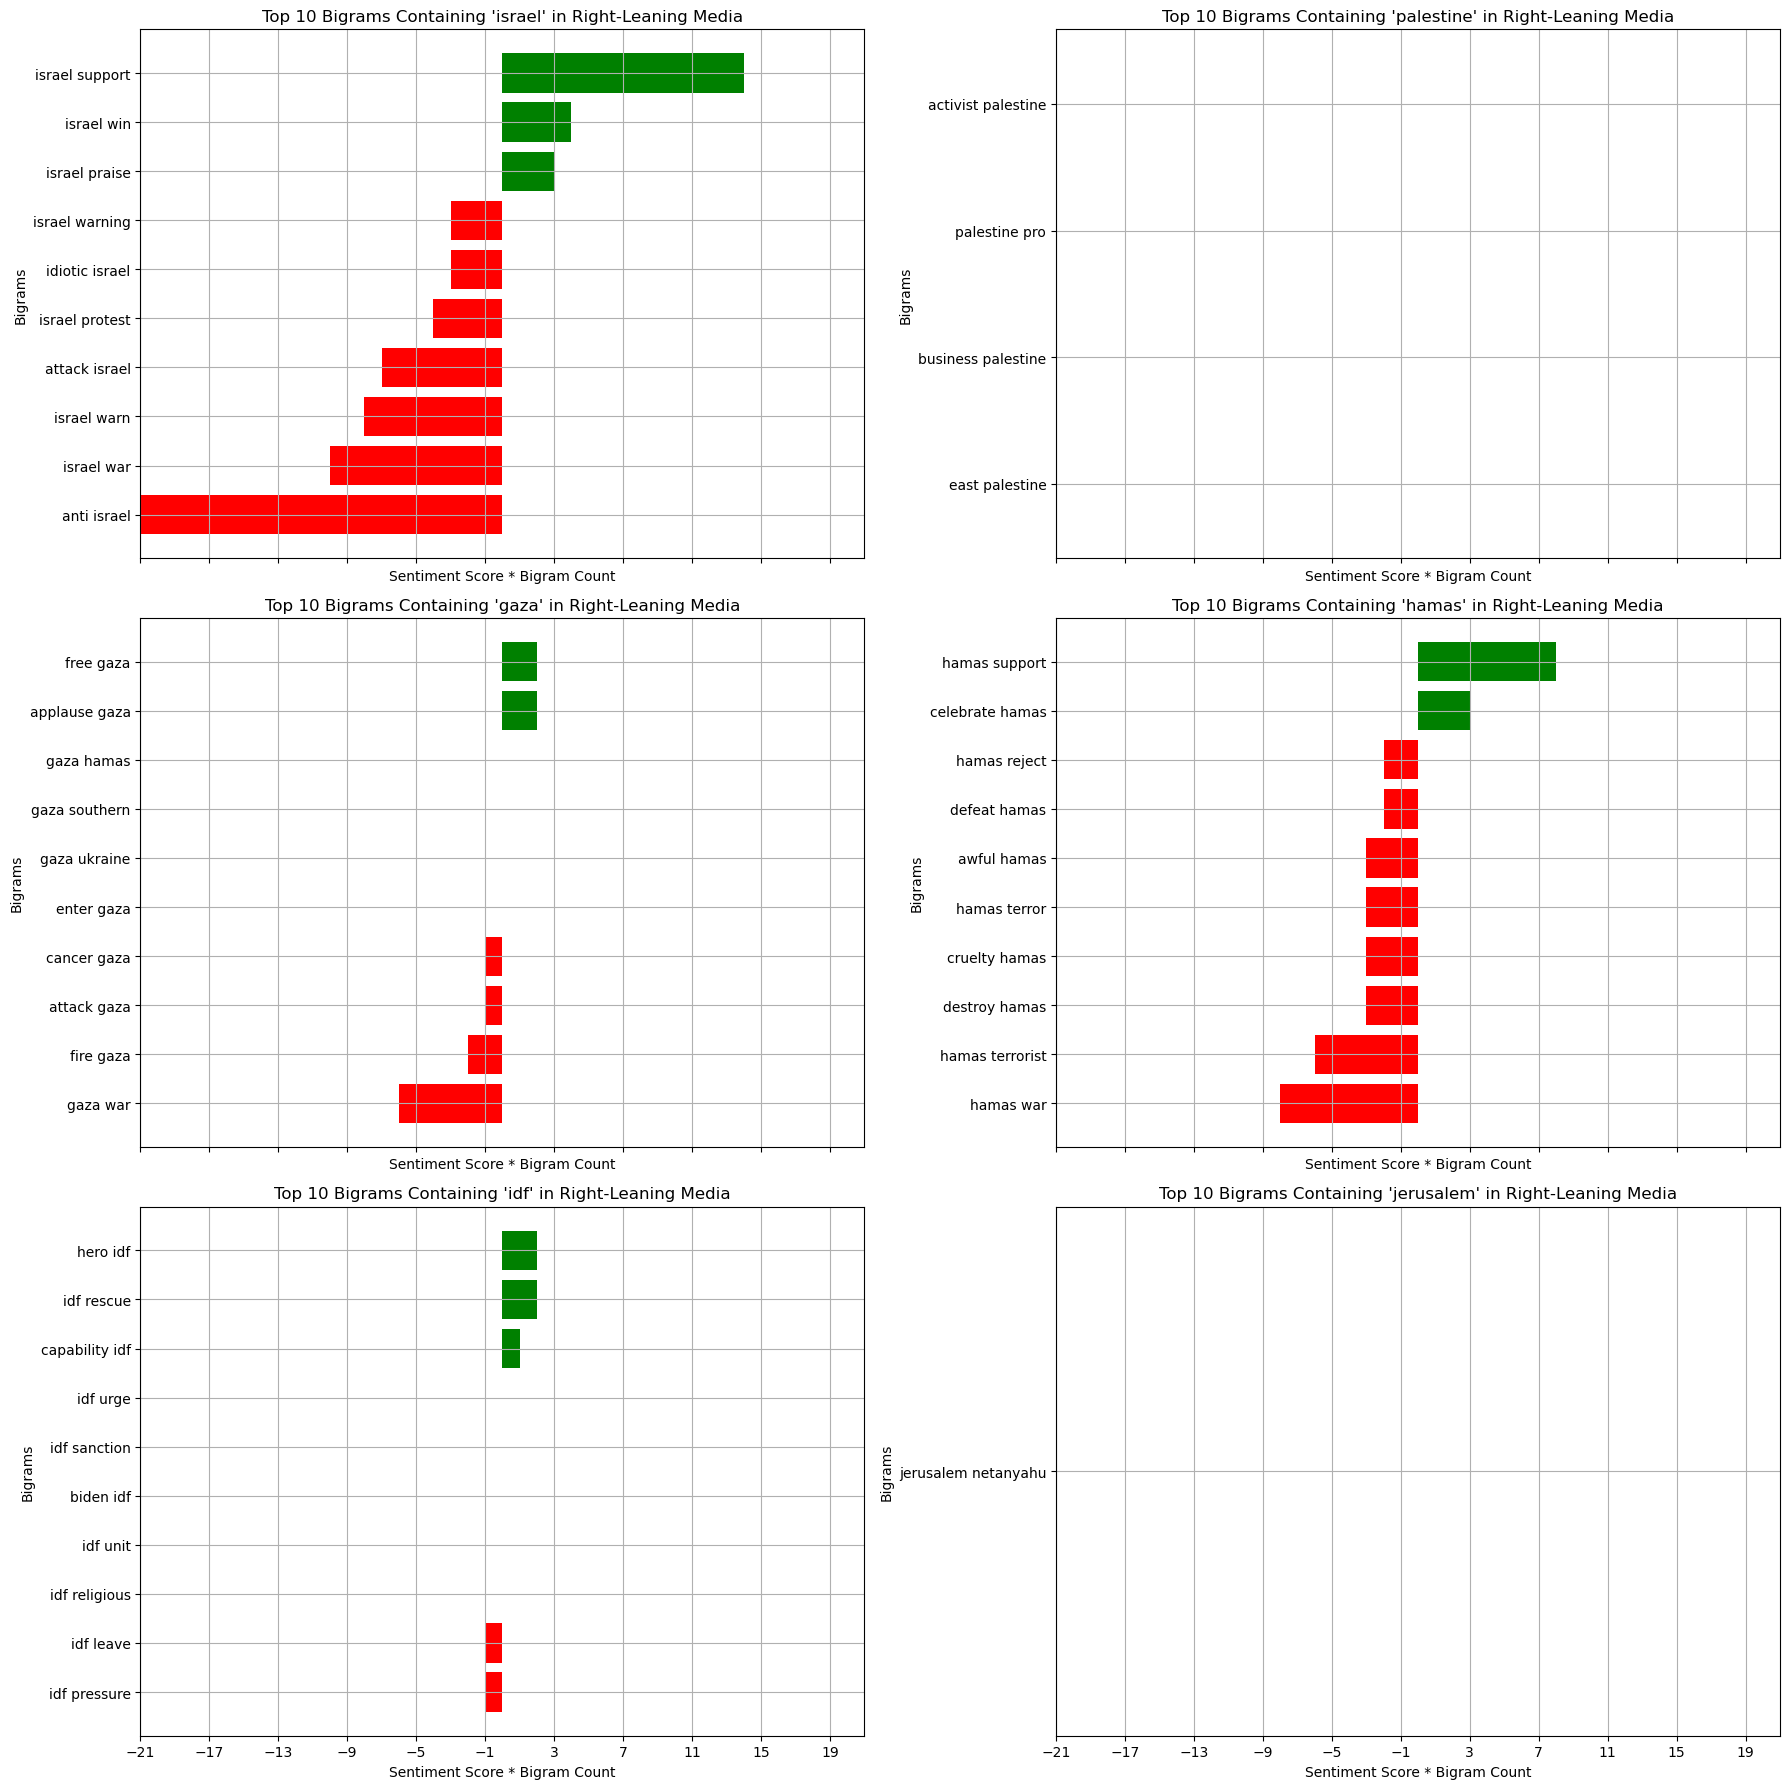

In [464]:
import networkx as nx
from nltk import ngrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
from afinn import Afinn

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Key terms for analysis
key_terms = ["israel", "palestine", "gaza", "hamas", "idf", "jerusalem"]

# Initialize Afinn sentiment analyzer
afinn = Afinn()

# Function to preprocess text
def preprocess_text(text):
    return text.lower()

# Function to extract bigrams from headlines
def get_bigrams(df):
    bigrams_list = []
    for headline in df["filtered_headline_no_synonym"]:
        processed_headline = preprocess_text(headline)
        words = nltk.word_tokenize(processed_headline)  # Tokenize words
        bigrams = list(ngrams(words, 2))  # Extract bigrams
        # Filter bigrams containing a term in key_terms
        filtered_bigrams = [tuple(sorted(bigram)) for bigram in bigrams if any(term in bigram for term in key_terms)]
        bigrams_list.extend(filtered_bigrams)
    return bigrams_list

# Function to count bigram occurrences
def count_bigrams(bigrams_list):
    return Counter(bigrams_list)

# Function to analyze bigrams and plot results
def analyze_and_plot_bigrams(df, media_label):
    bigrams_list = get_bigrams(df)
    bigrams_count = count_bigrams(bigrams_list)
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 18), sharex=True)
    axes = axes.flatten()
    
    all_scores = []
    
    for i, term in enumerate(key_terms):
        term_bigrams = {bigram: count for bigram, count in bigrams_count.items() if term in bigram}
        
        if not term_bigrams:
            continue  # Skip if no bigrams contain the term
        
        # Calculate sentiment score for each bigram
        bigram_sentiment = {bigram: afinn.score(' '.join(bigram)) for bigram in term_bigrams.keys()}
        
        # Calculate sentiment score * bigram count
        bigram_sentiment_score = {bigram: score * term_bigrams[bigram] for bigram, score in bigram_sentiment.items()}
        
        # Get the top 10 bigrams by absolute sentiment score * bigram count
        top_bigrams = sorted(bigram_sentiment_score.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
        
        # Prepare data for plotting
        bigrams, sentiment_scores = zip(*top_bigrams)
        bigram_counts = [term_bigrams[bigram] for bigram in bigrams]
        real_sentiments = [bigram_sentiment[bigram] for bigram in bigrams]
        
        # Sort bigrams by sentiment score * bigram count values
        sorted_indices = sorted(range(len(sentiment_scores)), key=lambda k: sentiment_scores[k])
        bigrams = [bigrams[idx] for idx in sorted_indices]
        sentiment_scores = [sentiment_scores[idx] for idx in sorted_indices]
        real_sentiments = [real_sentiments[idx] for idx in sorted_indices]
        
        all_scores.extend(sentiment_scores)
        
        # Plot the results
        ax = axes[i]
        
        colors = ['green' if score > 0 else 'red' for score in sentiment_scores]
        ax.barh([' '.join(bigram) for bigram in bigrams], sentiment_scores, color=colors)
        ax.set_xlabel('Sentiment Score * Bigram Count')
        ax.set_ylabel('Bigrams')
        ax.set_title(f"Top 10 Bigrams Containing '{term}' in {media_label} Media")
        ax.grid(True)  # Enable grid lines
    
    # Set the same x-axis limits for all subplots
    max_abs_score = int(max(abs(min(all_scores)), abs(max(all_scores))))
    for ax in axes:
        ax.set_xlim(-max_abs_score, max_abs_score)
        ax.set_xticks(range(-max_abs_score, max_abs_score + 1, max_abs_score // 5))
    
    fig.tight_layout()
    plt.savefig(f"plots/bigrams_{media_label.lower().replace('-', '_')}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

def highlight_zeros(val):
    color = 'darkgray' if val == 0 else ''
    return f'background-color: {color}'


# Example usage
analyze_and_plot_bigrams(df_left, "Left-Leaning")
analyze_and_plot_bigrams(df_right, "Right-Leaning")


[nltk_data] Downloading package punkt to /Users/pc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


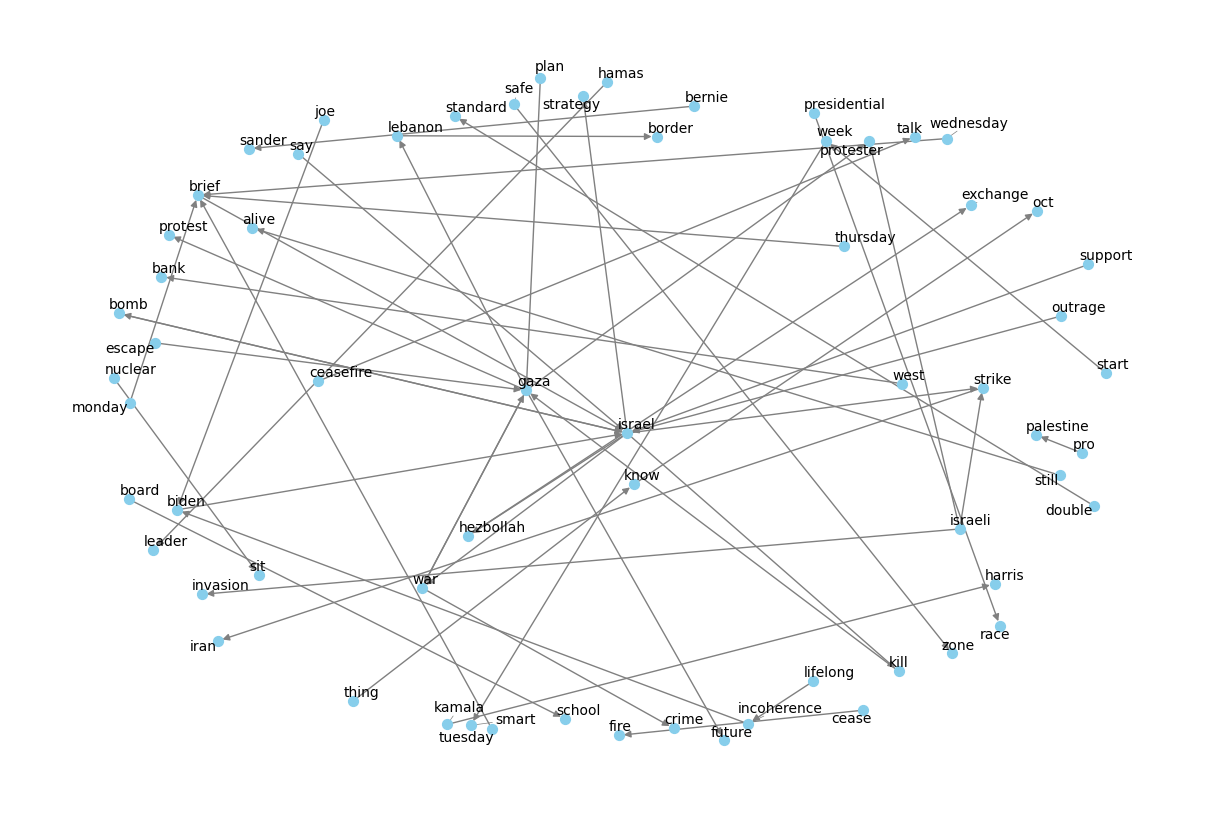

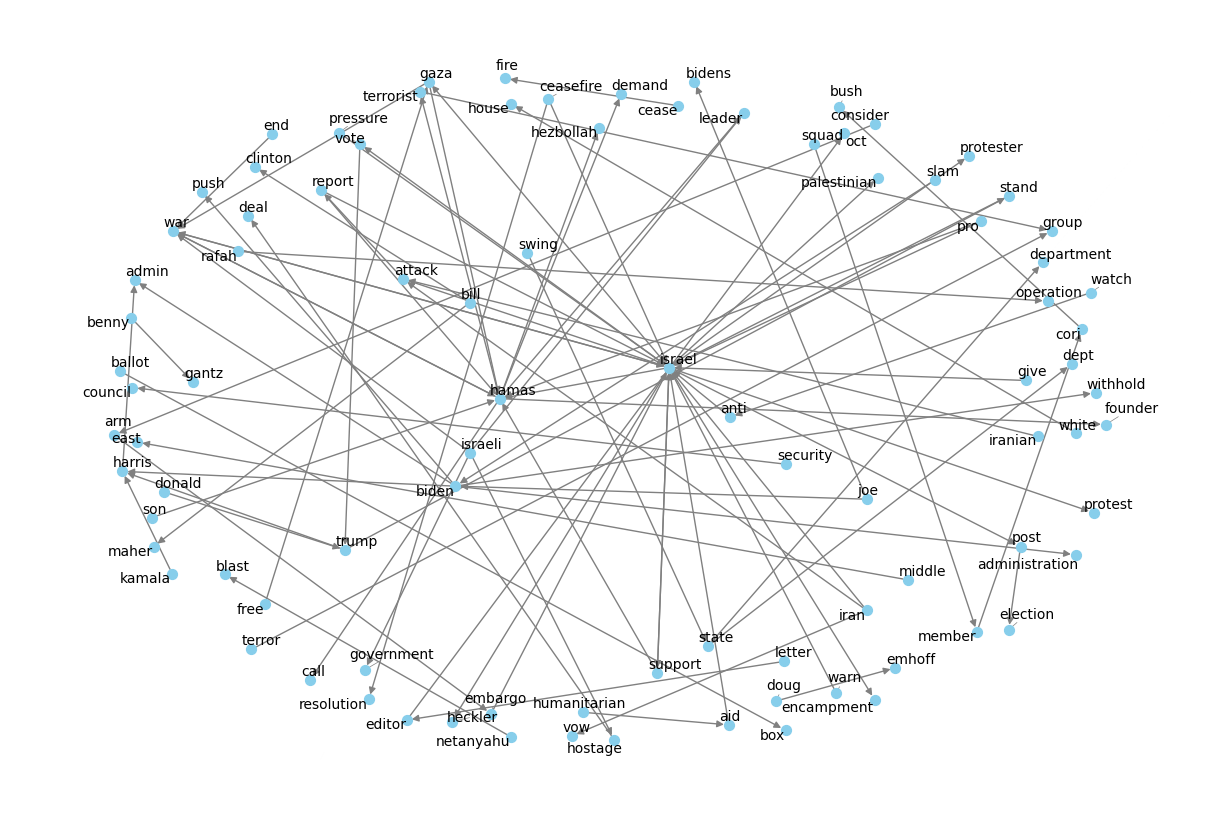

In [504]:
import networkx as nx
from nltk import ngrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
import string
from adjustText import adjust_text

# Ensure NLTK resources are downloaded
nltk.download('punkt')
key_terms = ["israel", "palestine", "gaza", "hamas", "idf", "jerusalem"]

# Function to preprocess text
def preprocess_text(text):
    # Remove punctuation and apostrophes
    text = text.translate(str.maketrans('', '', string.punctuation.replace("'", "")))
    text = text.replace("'", "")
    return text.lower()

# Function to extract bigrams from headlines containing key terms
def get_bigrams(df):
    bigrams_list = []
    for headline in df["filtered_headline_no_synonym"]:
        if any(term in headline.lower() for term in key_terms):
            processed_headline = preprocess_text(headline)
            words = nltk.word_tokenize(processed_headline)  # Tokenize words
            bigrams = list(ngrams(words, 2))  # Extract bigrams
            # Filter out bigrams with a word containing only a single letter
            filtered_bigrams = [bigram for bigram in bigrams if all(len(word) > 2 for word in bigram)]
            bigrams_list.extend(filtered_bigrams)
    return bigrams_list

# Function to count bigram occurrences
def count_bigrams(bigrams_list):
    return Counter(bigrams_list)

# Function to generate and plot a bigram network
def plot_bigram_network(bigrams_count, media_label, threshold=10):
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges with weight threshold
    for (word1, word2), count in bigrams_count.items():
        if count >= threshold:
            G.add_edge(word1, word2, weight=count, label=count)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=1.5)  # Increase k for more separation
    nx.draw(G, pos, with_labels=False, node_size=50, edge_color="gray", font_size=10, node_color="skyblue")
    
    # Draw node labels next to the nodes
    texts = [plt.text(pos[node][0], pos[node][1], node, fontsize=10, ha='right') for node in G.nodes()]
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
    plt.savefig(f"plots/bigram_network_{media_label.lower().replace('-', '_')}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

bigrams_list = get_bigrams(df_left)
bigrams_count = count_bigrams(bigrams_list)
plot_bigram_network(bigrams_count, "Left-Leaning", threshold=2)
bigrams_list = get_bigrams(df_right)
bigrams_count = count_bigrams(bigrams_list)
plot_bigram_network(bigrams_count, "Right-Leaning", threshold=2)


In [400]:
df_left.to_csv("stories_left.csv", index=False)
df_right.to_csv("stories_right.csv", index=False)
df_center.to_csv("stories_center.csv", index=False)

# LDA

In [421]:
import numpy as np

# Tokenize the filtered text

df_left["tokens"] = df_left["filtered_text"].apply(lambda x: x.split())
df_right["tokens"] = df_right["filtered_text"].apply(lambda x: x.split())
df_center["tokens"] = df_center["filtered_text"].apply(lambda x: x.split())

# Create dictionary and corpus for LDA
vectorizer_left = CountVectorizer()
X_left = vectorizer_left.fit_transform(df_left["filtered_text"])

vectorizer_right = CountVectorizer()
X_right = vectorizer_right.fit_transform(df_right["filtered_text"])

vectorizer_center = CountVectorizer()
X_center = vectorizer_center.fit_transform(df_center["filtered_text"])

# Train LDA for left-leaning headlines
num_topics = 3
lda_model_left = lda.LDA(n_topics=num_topics, n_iter=1500, random_state=42)
lda_model_left.fit(X_left)

# Train LDA for right-leaning headlines
lda_model_right = lda.LDA(n_topics=num_topics, n_iter=1500, random_state=42)
lda_model_right.fit(X_right)

# Train LDA for center-leaning headlines
lda_model_center = lda.LDA(n_topics=num_topics, n_iter=1500, random_state=42)
lda_model_center.fit(X_center)

# Print top words per topic for left-leaning headlines
vocab_left = vectorizer_left.get_feature_names_out()
print("Topics for Left-Leaning Headlines:")
for i, topic_dist in enumerate(lda_model_left.topic_word_):
    topic_words = np.array(vocab_left)[np.argsort(topic_dist)][:-(num_topics+1):-1]
    print(f'Topic {i}: {" ".join(topic_words)}')

# Print top words per topic for right-leaning headlines
vocab_right = vectorizer_right.get_feature_names_out()
print("Topics for Right-Leaning Headlines:")
for i, topic_dist in enumerate(lda_model_right.topic_word_):
    topic_words = np.array(vocab_right)[np.argsort(topic_dist)][:-(num_topics+1):-1]
    print(f'Topic {i}: {" ".join(topic_words)}')

# Print top words per topic for center-leaning headlines
vocab_center = vectorizer_center.get_feature_names_out()
print("Topics for Center-Leaning Headlines:")
for i, topic_dist in enumerate(lda_model_center.topic_word_):
    topic_words = np.array(vocab_center)[np.argsort(topic_dist)][:-(num_topics+1):-1]
    print(f'Topic {i}: {" ".join(topic_words)}')


INFO:lda:n_documents: 3940
INFO:lda:vocab_size: 2632
INFO:lda:n_words: 18163
INFO:lda:n_topics: 3
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -188553
INFO:lda:<10> log likelihood: -152904
INFO:lda:<20> log likelihood: -151152
INFO:lda:<30> log likelihood: -150414
INFO:lda:<40> log likelihood: -149932
INFO:lda:<50> log likelihood: -149697
INFO:lda:<60> log likelihood: -149440
INFO:lda:<70> log likelihood: -149134
INFO:lda:<80> log likelihood: -149206
INFO:lda:<90> log likelihood: -148880
INFO:lda:<100> log likelihood: -148904
INFO:lda:<110> log likelihood: -148830
INFO:lda:<120> log likelihood: -148852
INFO:lda:<130> log likelihood: -148913
INFO:lda:<140> log likelihood: -148662
INFO:lda:<150> log likelihood: -148724
INFO:lda:<160> log likelihood: -148577
INFO:lda:<170> log likelihood: -148551
INFO:lda:<180> log likelihood: -148549
INFO:lda:<190> log likelihood: -148500
INFO:lda:<200> log likelihood: -148400
INFO:lda:<210> log likelihood: -148439
INFO:lda:<220> log likelihood: -1

Topics for Left-Leaning Headlines:
Topic 0: israel war gaza
Topic 1: win abortion arizona
Topic 2: california moment help
Topics for Right-Leaning Headlines:
Topic 0: immigration border win
Topic 1: israel war lead
Topic 2: win business economy
Topics for Center-Leaning Headlines:
Topic 0: israel war ukraine
Topic 1: abortion georgia race
Topic 2: trial money hush


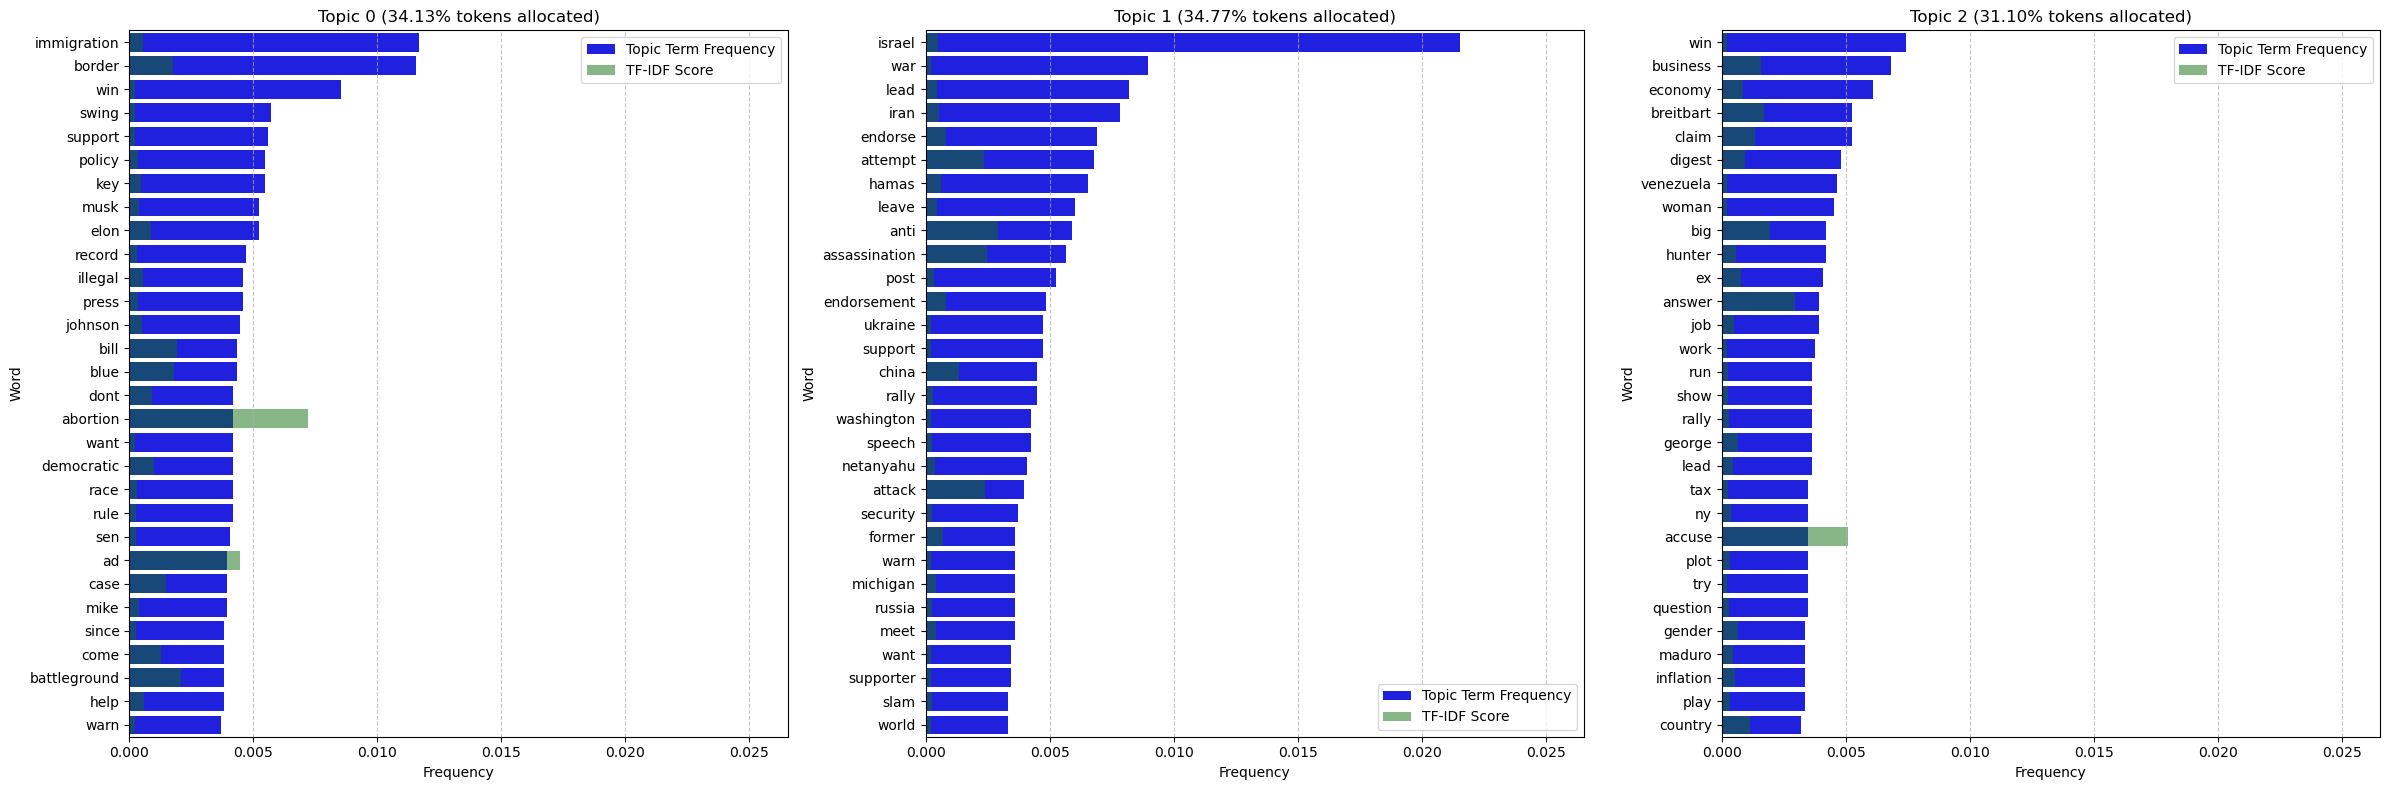

In [498]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_means_left = tfidf_df_left.mean().sort_values(ascending=False)
tfidf_means_center = tfidf_df_center.mean().sort_values(ascending=False)
tfidf_means_right = tfidf_df_right.mean().sort_values(ascending=False)

def plot_topic_terms(lda_model, tfidf_means, vocab, topic_id, title_prefix, x_max, ax):
    # Get the top 30 terms for the selected topic
    topic_word_dist = lda_model.topic_word_[topic_id]
    top_word_indices = np.argsort(topic_word_dist)[-30:]
    top_words = [(vocab[i], topic_word_dist[i]) for i in top_word_indices]

    # Convert to DataFrame for plotting
    top_words_df = pd.DataFrame(top_words, columns=["word", "topic_weight"])

    # Calculate the TF-IDF scores
    tfidf_scores = tfidf_means.iloc[top_word_indices].values
    top_words_df["tfidf_score"] = tfidf_scores

    # Calculate the percentage of tokens allocated to the selected topic
    doc_topic_dist = lda_model.doc_topic_
    num_tokens_allocated = np.sum(doc_topic_dist[:, topic_id])
    total_tokens = np.sum(doc_topic_dist)
    percentage_tokens_allocated = (num_tokens_allocated / total_tokens) * 100

    # Reverse the order of the words
    top_words_df = top_words_df.iloc[::-1]

    # Plot bar chart showing both topic term frequency and TF-IDF scores
    sns.barplot(x="topic_weight", y="word", data=top_words_df, color="blue", label="Topic Term Frequency", ax=ax)
    sns.barplot(x="tfidf_score", y="word", data=top_words_df, color="green", alpha=0.5, label="TF-IDF Score", ax=ax)

    ax.set_title(f"Topic {topic_id} ({percentage_tokens_allocated:.2f}% tokens allocated)")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Word")
    ax.legend()
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    ax.set_xlim(0, x_max+0.005)

# Calculate the maximum x-axis limit across all plots
x_max = max(np.max(lda_model_right.topic_word_), np.max(tfidf_means_right))

# Create a 3-column, 1-row layout for the plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Example usage
plot_topic_terms(lda_model_right, tfidf_means_right, vocab_right, topic_id=0, title_prefix="Right-Leaning", x_max=x_max, ax=axes[0])
plot_topic_terms(lda_model_right, tfidf_means_right, vocab_right, topic_id=1, title_prefix="Right-Leaning", x_max=x_max, ax=axes[1])
plot_topic_terms(lda_model_right, tfidf_means_right, vocab_right, topic_id=2, title_prefix="Right-Leaning", x_max=x_max, ax=axes[2])

plt.tight_layout()
plt.savefig("plots/topic_terms_right.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

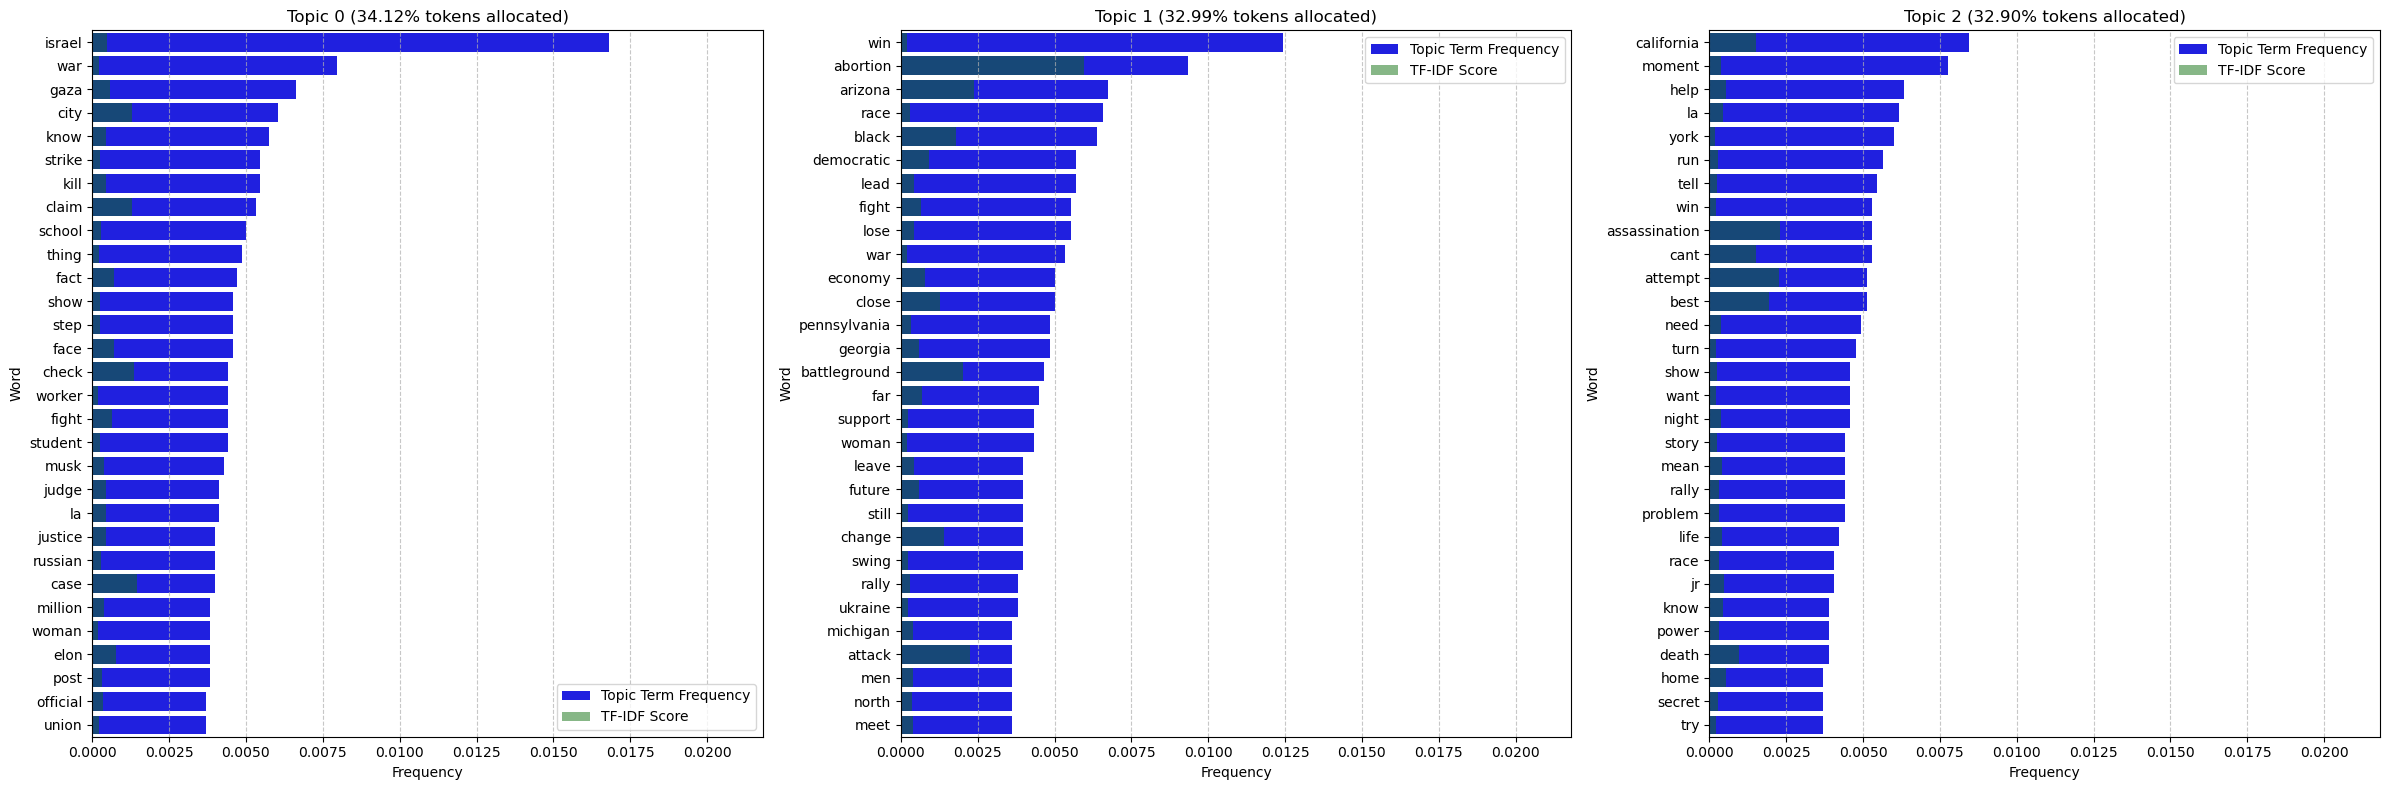

In [499]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
x_max = max(np.max(lda_model_left.topic_word_), np.max(tfidf_means_left))
plot_topic_terms(lda_model_left, tfidf_means_left, vocab_left, topic_id=0, title_prefix="Left-Leaning",x_max=x_max, ax = axes[0])
plot_topic_terms(lda_model_left, tfidf_means_left, vocab_left, topic_id=1, title_prefix="Left-Leaning",x_max=x_max, ax = axes[1])
plot_topic_terms(lda_model_left, tfidf_means_left, vocab_left, topic_id=2, title_prefix="Left-Leaning",x_max=x_max, ax = axes[2])
plt.tight_layout()
plt.savefig("plots/topic_terms_left.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

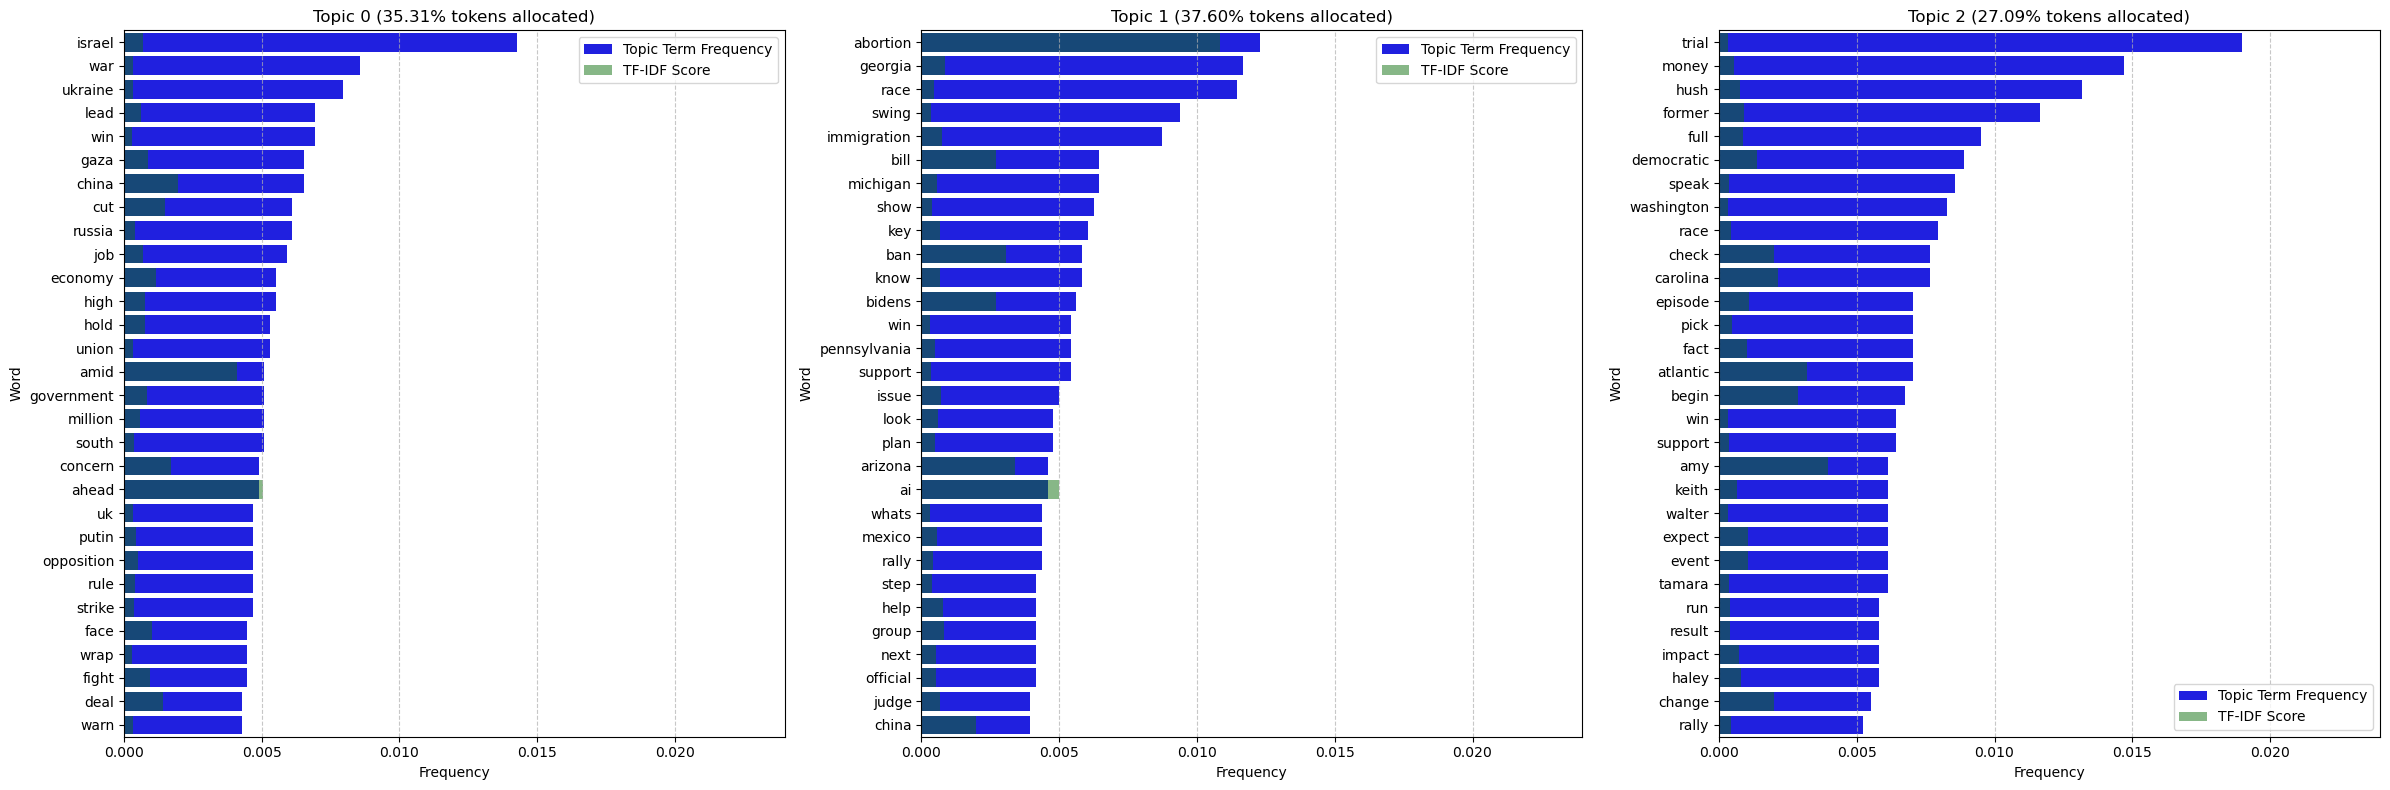

In [500]:
x_max = max(np.max(lda_model_center.topic_word_), np.max(tfidf_means_center))
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Example usage
plot_topic_terms(lda_model_center, tfidf_means_center, vocab_center, topic_id=0, title_prefix="Center-Leaning",x_max=x_max, ax=axes[0])
plot_topic_terms(lda_model_center, tfidf_means_center, vocab_center, topic_id=1, title_prefix="Center-Leaning",x_max=x_max, ax=axes[1])
plot_topic_terms(lda_model_center, tfidf_means_center, vocab_center, topic_id=2, title_prefix="Center-Leaning",x_max=x_max, ax=axes[2])
plt.tight_layout()
plt.savefig("plots/topic_terms_center.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [437]:
# Function to assign topics to headlines
def assign_topics(lda_model, X):
    doc_topic_dist = lda_model.doc_topic_
    return np.argmax(doc_topic_dist, axis=1)

# Assign topics to left-leaning headlines
df_left['assigned_topic'] = assign_topics(lda_model_left, tfidf_matrix_left)

# Assign topics to right-leaning headlines
df_right['assigned_topic'] = assign_topics(lda_model_right, tfidf_matrix_right)

# Assign topics to center-leaning headlines
df_center['assigned_topic'] = assign_topics(lda_model_center, tfidf_matrix_center)

# Display the first few rows of the dataframes with assigned topics
print(df_left[['headline', 'assigned_topic']].tail(10))
print(df_right[['headline', 'assigned_topic']].tail(10))
print(df_center[['headline', 'assigned_topic']].tail(10))

                                                     headline  assigned_topic
datetime                                                                     
2024-11-05  L.A. County homeless tax ahead in early return...               0
2024-11-05  Live updates: Senate, House and gubernatorial ...               1
2024-11-05  Video captures altercation between police and ...               2
2024-11-05                        Latino Voter Misinformation               0
2024-11-05  Pennsylvania’s Undecided Voters Might Swing Th...               1
2024-11-05                          Letters: Internal Dissent               0
2024-11-05         How to Watch Election Night Like an Expert               2
2024-11-05  MAGA Main Character Syndrome Is Going Into Ove...               1
2024-11-05                      Hickey Freeman's Next Chapter               2
2024-11-05  Abcarian: Trump would allow RFK Jr. to infect ...               2
                                                     headline  a

In [441]:
df_left.to_csv("stories_left.csv", index=False)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

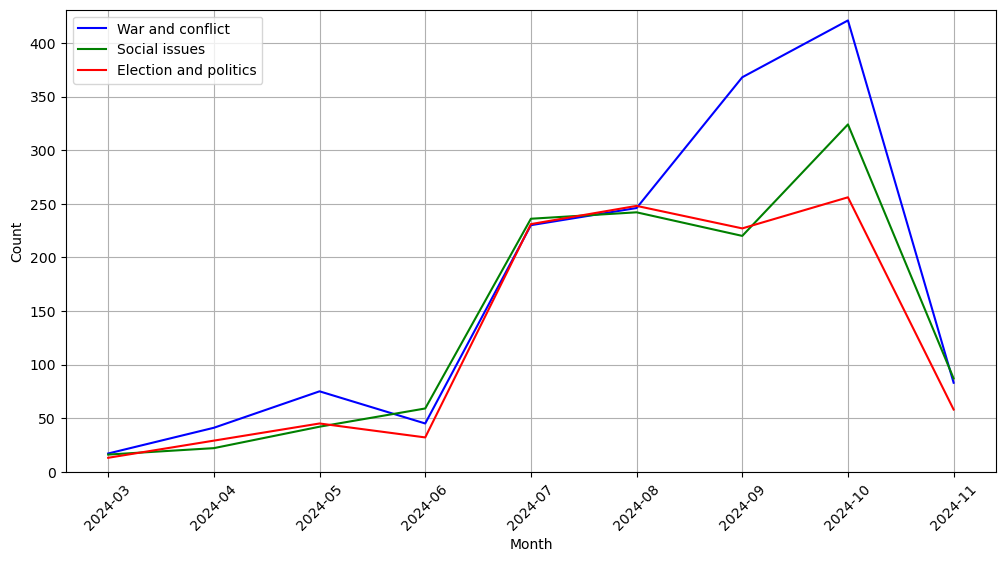

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

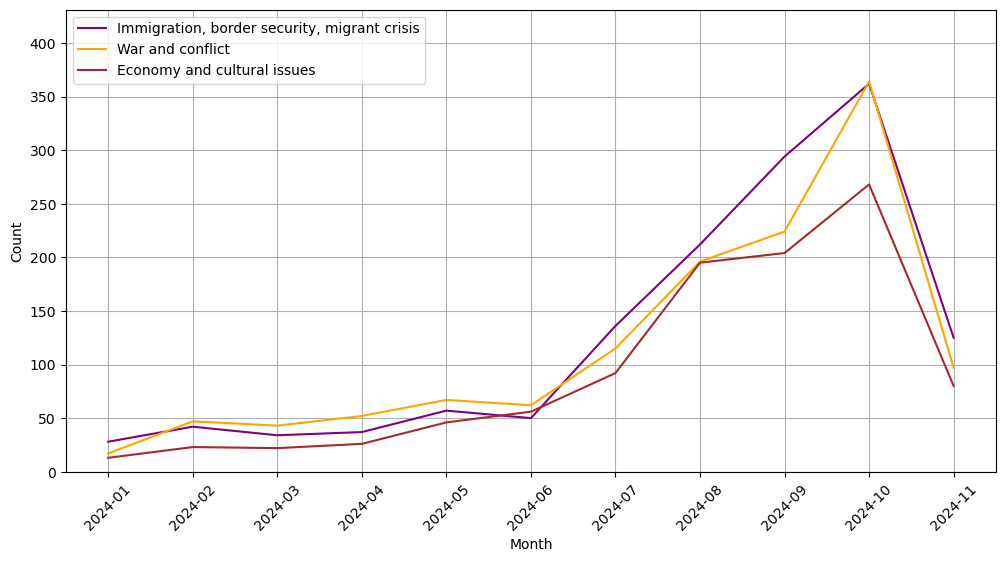

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

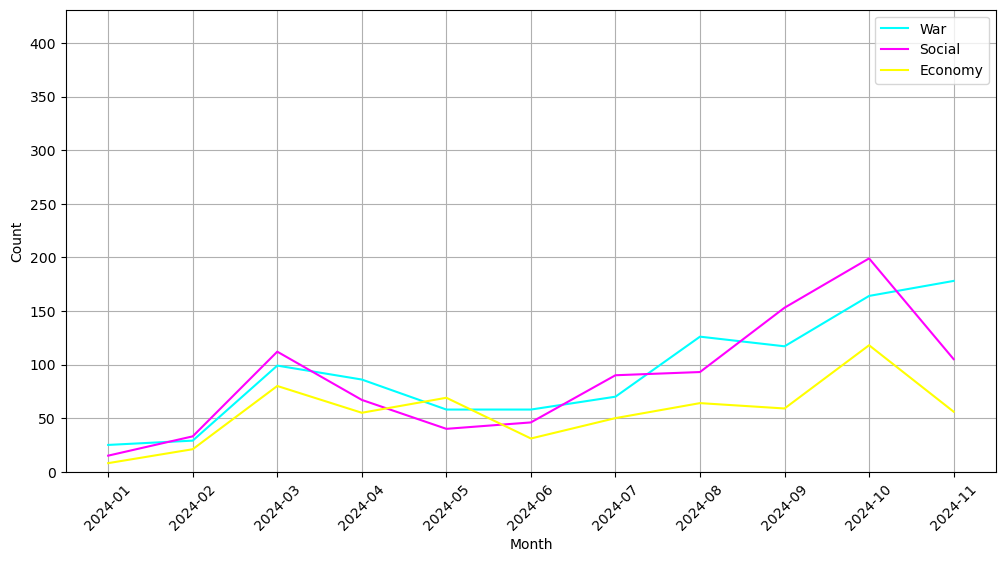

In [508]:
import matplotlib.pyplot as plt

# Function to plot topic trends over time
def plot_topic_trends(df, title, topic_descriptions, y_lim, colors, skip=False):
    # Filter out the first two months if start_date is provided
    if skip:
        df = df[df.index >= (df.index.min() + pd.DateOffset(months=2))]
    
    # Group by month and topic to count occurrences
    topic_trends = df.groupby([df.index.to_period('M'), 'assigned_topic']).size().reset_index(name='count')
    
    plt.figure(figsize=(12, 6))
    for topic in topic_trends['assigned_topic'].unique():
        topic_data = topic_trends[topic_trends['assigned_topic'] == topic]
        plt.plot(topic_data['datetime'].astype(str), topic_data['count'], label=topic_descriptions[topic], color=colors[topic])
    
    plt.xlabel('Month')
    plt.ylabel('Count')

    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.ylim(0, y_lim)
    plt.savefig(f"plots/{title.lower().replace(' ', '_')}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Topic descriptions for left-leaning headlines
left_topic_descriptions = {
    0: 'War and conflict',
    1: 'Social issues',
    2: 'Election and politics',
}

# Topic descriptions for right-leaning headlines
right_topic_descriptions = {
    0: 'Immigration, border security, migrant crisis',
    1: 'War and conflict',
    2: 'Economy and cultural issues',
}

center_topic_descriptions = {
    0: 'War',
    1: 'Social',
    2: 'Economy',
}

# Define color palettes for left and right topics
left_colors = ['blue', 'green', 'red']
right_colors = ['purple', 'orange', 'brown']
center_colors = ['cyan', 'magenta', 'yellow']

# Calculate the global y-axis limit
y_lim = max(
    df_left.groupby([df_left.index.to_period('M'), 'assigned_topic']).size().max(),
    df_right.groupby([df_right.index.to_period('M'), 'assigned_topic']).size().max(),
    df_center.groupby([df_center.index.to_period('M'), 'assigned_topic']).size().max()
)

# Plot topic trends for left-leaning headlines, filtering out the first two months
plot_topic_trends(df_left, 'Topic Trends Over Time in Left-Leaning Headlines', left_topic_descriptions, y_lim+10, left_colors, skip=True)

# Plot topic trends for right-leaning headlines
plot_topic_trends(df_right, 'Topic Trends Over Time in Right-Leaning Headlines', right_topic_descriptions, y_lim+10, right_colors)

# Plot topic trends for center-leaning headlines
plot_topic_trends(df_center, 'Topic Trends Over Time in Center-Leaning Headlines', center_topic_descriptions, y_lim+10, center_colors)
